In [1]:
## Libraries cell

## Importing data handling libraries
import pandas as pd
import numpy as np
from collections import OrderedDict
import itertools 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 

## Importing data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

## Importing statistics libraries
import scipy.stats as scipy_stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Importing miscelleaous libraries
import warnings
warnings.filterwarnings('ignore')

## Sklearn libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor


In [2]:
# Reading the data
df = pd.read_csv('Data (2).csv')
df2 =df.copy()

In [3]:
df

cement   slag    ash  water  superplastic  coarseagg  fineagg  age  \
0      141.3  212.0    0.0  203.5           0.0      971.8    748.5   28   
1      168.9   42.2  124.3  158.3          10.8     1080.8    796.2   14   
2      250.0    0.0   95.7  187.4           5.5      956.9    861.2   28   
3      266.0  114.0    0.0  228.0           0.0      932.0    670.0   28   
4      154.8  183.4    0.0  193.3           9.1     1047.4    696.7   28   
...      ...    ...    ...    ...           ...        ...      ...  ...   
1025   135.0    0.0  166.0  180.0          10.0      961.0    805.0   28   
1026   531.3    0.0    0.0  141.8          28.2      852.1    893.7    3   
1027   276.4  116.0   90.3  179.6           8.9      870.1    768.3   28   
1028   342.0   38.0    0.0  228.0           0.0      932.0    670.0  270   
1029   540.0    0.0    0.0  173.0           0.0     1125.0    613.0    7   

      strength  
0        29.89  
1        23.51  
2        29.22  
3        45.85  
4        18.29  
...        ...  
1025     13.29  
1026     41.30  
1027     44.28  
1028     55.06  
1029     52.61  

[1030 rows x 9 columns]

In [4]:
df.shape

(1030, 9)

In [5]:
def CustomSummary(df):
    result = []
    for col in list(df.columns):
            stats = OrderedDict({'FeatureName': col, 
                                 'Count':df[col].count(), 
                                 'Datatype': df[col].dtype, 
                                 'SD': round(df[col].std(), 2), 
                                 'Var': round(df[col].var(), 2), 
                                 'Min': round(df[col].min(), 2), 
                                 'Q1': round(df[col].quantile(0.25), 2), 
                                 'Mean': round(df[col].mean(), 2),
                                 'Median': round(df[col].median(), 2), 
                                 'Q3': round(df[col].quantile(0.75), 2), 
                                 'Max': round(df[col].max(), 2), 
                                 'Range': round(df[col].quantile(1), 2) - round(df[col].quantile(0), 2), 
                                 'IQR':round(df[col].quantile(0.75), 2)-round(df[col].quantile(0.25), 2), 
                                 'Kurtosis': round(df[col].kurt(), 2), 
                                 'Skewness': round(df[col].skew(), 2)})
            result.append(stats)
            
            # Skewness comment
            if df[col].skew() < -1:
                sk_label = 'Highly Negatively Skewed'
            elif -1 <= df[col].skew() < -0.5:
                sk_label = 'Moderatey Negatively Skewed'
            elif -0.5 <= df[col].skew() < 0:
                sk_label = 'Fairly Symmetric(Negative)'
            elif 0 <= df[col].skew() < 0.5:
                sk_label = 'Fairly Symmetric(Positive)'
            elif 0.5 <= df[col].skew() < 1:
                sk_label = 'Moderatey Positively Skewed'
            elif  df[col].skew() > 1:
                sk_label = 'Highly Positively Skewed'
            else:
                sk_label = 'Error'
            stats['Skewness Comment'] = sk_label
            
            # Outlier detection(boundaries from the box plot)
            Upper_lim = stats['Q3'] + (1.5 * stats['IQR'])
            Lower_lim = stats['Q1'] - (1.5 * stats['IQR'])
            if len([x for x in df[col] if x < Lower_lim or x > Upper_lim]) > 0:
                Out_Label = 'Has Outlier'
            else:
                Out_Label = 'No Outliers'
            stats['Outlier Comment'] = Out_Label
    resultdf = pd.DataFrame(data= result)
    resultdf = resultdf.set_index("FeatureName")
    return resultdf


In [6]:
CustomSummary(df)

Count Datatype      SD       Var     Min      Q1    Mean  \
FeatureName                                                              
cement         1030  float64  104.51  10921.58  102.00  192.38  281.17   
slag           1030  float64   86.28   7444.12    0.00    0.00   73.90   
ash            1030  float64   64.00   4095.62    0.00    0.00   54.19   
water          1030  float64   21.35    456.00  121.80  164.90  181.57   
superplastic   1030  float64    5.97     35.69    0.00    0.00    6.20   
coarseagg      1030  float64   77.75   6045.68  801.00  932.00  972.92   
fineagg        1030  float64   80.18   6428.19  594.00  730.95  773.58   
age            1030    int64   63.17   3990.44    1.00    7.00   45.66   
strength       1030  float64   16.71    279.08    2.33   23.71   35.82   

              Median       Q3     Max   Range     IQR  Kurtosis  Skewness  \
FeatureName                                                                 
cement        272.90   350.00   540.0  438.00  157.62     -0.52      0.51   
slag           22.00   142.95   359.4  359.40  142.95     -0.51      0.80   
ash             0.00   118.30   200.1  200.10  118.30     -1.33      0.54   
water         185.00   192.00   247.0  125.20   27.10      0.12      0.07   
superplastic    6.40    10.20    32.2   32.20   10.20      1.41      0.91   
coarseagg     968.00  1029.40  1145.0  344.00   97.40     -0.60     -0.04   
fineagg       779.50   824.00   992.6  398.60   93.05     -0.10     -0.25   
age            28.00    56.00   365.0  364.00   49.00     12.17      3.27   
strength       34.45    46.14    82.6   80.27   22.43     -0.31      0.42   

                         Skewness Comment Outlier Comment  
FeatureName                                                
cement        Moderatey Positively Skewed     No Outliers  
slag          Moderatey Positively Skewed     Has Outlier  
ash           Moderatey Positively Skewed     No Outliers  
water          Fairly Symmetric(Positive)     Has Outlier  
superplastic  Moderatey Positively Skewed     Has Outlier  
coarseagg      Fairly Symmetric(Negative)     No Outliers  
fineagg        Fairly Symmetric(Negative)     Has Outlier  
age              Highly Positively Skewed     Has Outlier  
strength       Fairly Symmetric(Positive)     Has Outlier

## Outlier Treatment

In [7]:
def OutlierTreatment(df,col,method='quartile',strategy='median'):
    col_data = df[col]
    q1,q2,q3 = col_data.quantile([0.25,0.5,0.75])
    mean = col_data.mean()
    median = q2
    std = col_data.std()
    
    # Certain outlier boundaries using quartile number
    if method == 'quartile':
        IQR = q3 - q1
        upper_limit = q3 + (1.5 * IQR)
        lower_limit = q1 - (1.5 * IQR)
        
    # Setting outlier boundry using STD method
    elif method == 'stdev':
        cutoff = std * 2
        lower_limit = mean - cutoff
        upper_limit = mean + cutoff
    else:
        print("Error! Please pass the correct method")
    
    # Printing outliers
    outliers = df.loc[(col_data < lower_limit) | (col_data > upper_limit),col]
    outlier_density = round((len(outliers) / len(df))* 100,2) # density of outliers count.Density is less than 2 % drop
    if len(outliers) == 0:
        print(f"Feature {col} does not have any outliers \n")
        print("-------**********--------")
    else:
        print(f"Replacing outliers for {col} \n")
        print(f"Total number of outliers for {col} are: {len(outliers)} \n")
        print(f"Density of the outlier for {col} is : {outlier_density} \n")
        print(f"Outlier for {col} are {np.sort(np.array(outliers))}")
        display(df[(col_data < lower_limit) | (col_data > upper_limit)])
        
    # Replacing with mean or median
    if strategy == 'median':
        df.loc[(col_data < lower_limit) | (col_data > upper_limit),col] = median
    elif strategy == 'mean':
        df.loc[(col_data < lower_limit) | (col_data > upper_limit),col] = mean
    else:
        print("Select a proper strategy")
    return df

## Outlier detection plots(ODT)

In [8]:
def odtplot(df,column):
    f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,10)) # 1 row 3 graphs
    kwargs = {'fontsize':20,'color':'black'} # multiple and repeatitive arguments used in kwargs
    # Plotting boxplot
    sns.boxplot(df[column],ax=ax1,orient='v',color='red') # vertical orientation
    ax1.set_title(column + ' boxplot', **kwargs)
    ax1.set_xlabel('Boxplot distribution', **kwargs)
    ax1.set_ylabel('Column values', **kwargs)
    
    # histogram with outliers
    sns.distplot(df[column],ax=ax2,color='green',fit=scipy_stats.norm) # fit using for show normal dist
    ax2.set_title(column + ' histogram with oultiers', **kwargs)
    ax2.set_xlabel('histogram distribution', **kwargs)
    ax2.set_ylabel('Column values', **kwargs)
    ax2.axvline(df[column].mean(),color = 'red',linestyle='dashed')
    ax2.axvline(df[column].median(),color = 'black',linestyle='dashed')
    
    # Histogram without outliers
    y = OutlierTreatment(df,column)
    sns.distplot(y[column],ax=ax3,color='green',fit=scipy_stats.norm) # fit using for show normal dist
    ax3.set_title(column + ' histogram without oultiers', **kwargs)
    ax3.set_xlabel('histogram distribution', **kwargs)
    ax3.set_ylabel('Column values', **kwargs)
    ax3.axvline(df[column].mean(),color = 'red',linestyle='dashed')
    ax3.axvline(df[column].median(),color = 'black',linestyle='dashed')
    
    plt.show()

Feature cement does not have any outliers 

-------**********--------


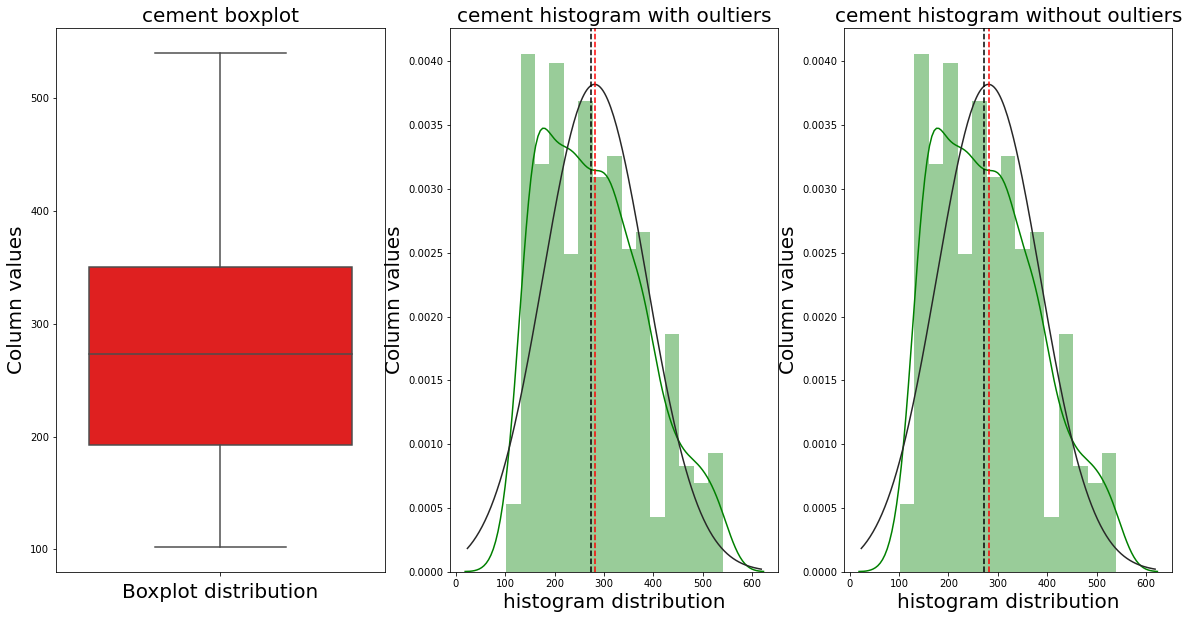

Replacing outliers for slag 

Total number of outliers for slag are: 2 

Density of the outlier for slag is : 0.19 

Outlier for slag are [359.4 359.4]


cement   slag  ash  water  superplastic  coarseagg  fineagg  age  \
918   239.6  359.4  0.0  185.7           0.0      941.6    664.3   28   
990   239.6  359.4  0.0  185.7           0.0      941.6    664.3    7   

     strength  
918     39.44  
990     25.42

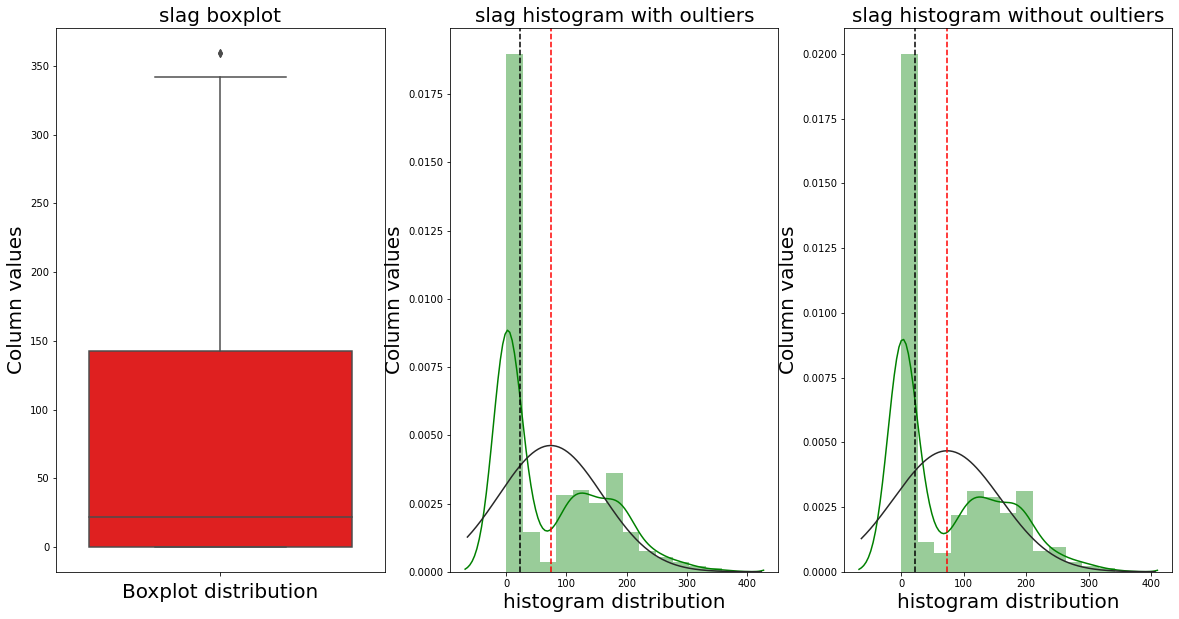

Feature ash does not have any outliers 

-------**********--------


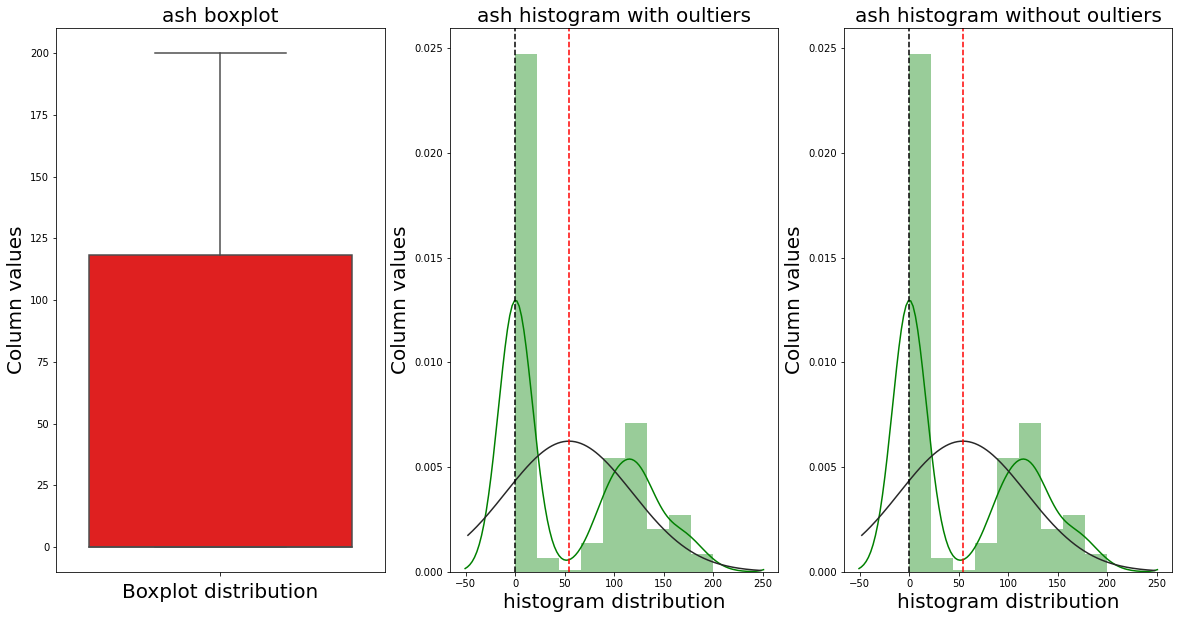

Replacing outliers for water 

Total number of outliers for water are: 9 

Density of the outlier for water is : 0.87 

Outlier for water are [121.8 121.8 121.8 121.8 121.8 236.7 237.  246.9 247. ]


cement   slag    ash  water  superplastic  coarseagg  fineagg  age  \
66    237.0   92.0   71.0  247.0           6.0      853.0    695.0   28   
263   236.9   91.7   71.5  246.9           6.0      852.9    695.4   28   
432   168.0   42.1  163.8  121.8           5.7     1058.7    780.1   28   
462   168.0   42.1  163.8  121.8           5.7     1058.7    780.1  100   
587   168.0   42.1  163.8  121.8           5.7     1058.7    780.1    3   
740   140.0  164.0  128.0  237.0           6.0      869.0    656.0   28   
789   168.0   42.1  163.8  121.8           5.7     1058.7    780.1   56   
826   139.7  163.9  127.7  236.7           5.8      868.6    655.6   28   
914   168.0   42.1  163.8  121.8           5.7     1058.7    780.1   14   

     strength  
66      28.63  
263     28.63  
432     24.24  
462     39.23  
587      7.75  
740     35.23  
789     32.85  
826     35.23  
914     17.82

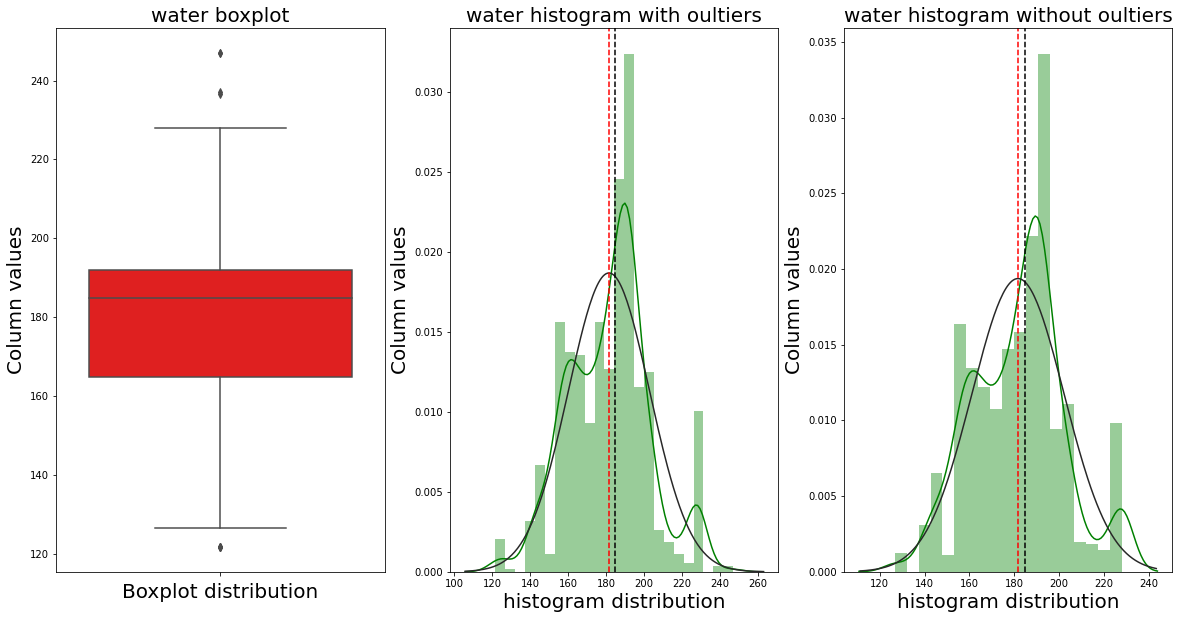

Replacing outliers for superplastic 

Total number of outliers for superplastic are: 10 

Density of the outlier for superplastic is : 0.97 

Outlier for superplastic are [28.2 28.2 28.2 28.2 28.2 32.2 32.2 32.2 32.2 32.2]


cement   slag  ash  water  superplastic  coarseagg  fineagg  age  \
44     531.3    0.0  0.0  141.8          28.2      852.1    893.7   91   
156    531.3    0.0  0.0  141.8          28.2      852.1    893.7   28   
232    469.0  117.2  0.0  137.8          32.2      852.1    840.5   56   
292    469.0  117.2  0.0  137.8          32.2      852.1    840.5   91   
538    531.3    0.0  0.0  141.8          28.2      852.1    893.7    7   
744    469.0  117.2  0.0  137.8          32.2      852.1    840.5    7   
816    469.0  117.2  0.0  137.8          32.2      852.1    840.5   28   
838    531.3    0.0  0.0  141.8          28.2      852.1    893.7   56   
955    469.0  117.2  0.0  137.8          32.2      852.1    840.5    3   
1026   531.3    0.0  0.0  141.8          28.2      852.1    893.7    3   

      strength  
44        59.2  
156       56.4  
232       69.3  
292       70.7  
538       46.9  
744       54.9  
816       66.9  
838       58.8  
955       40.2  
1026      41.3

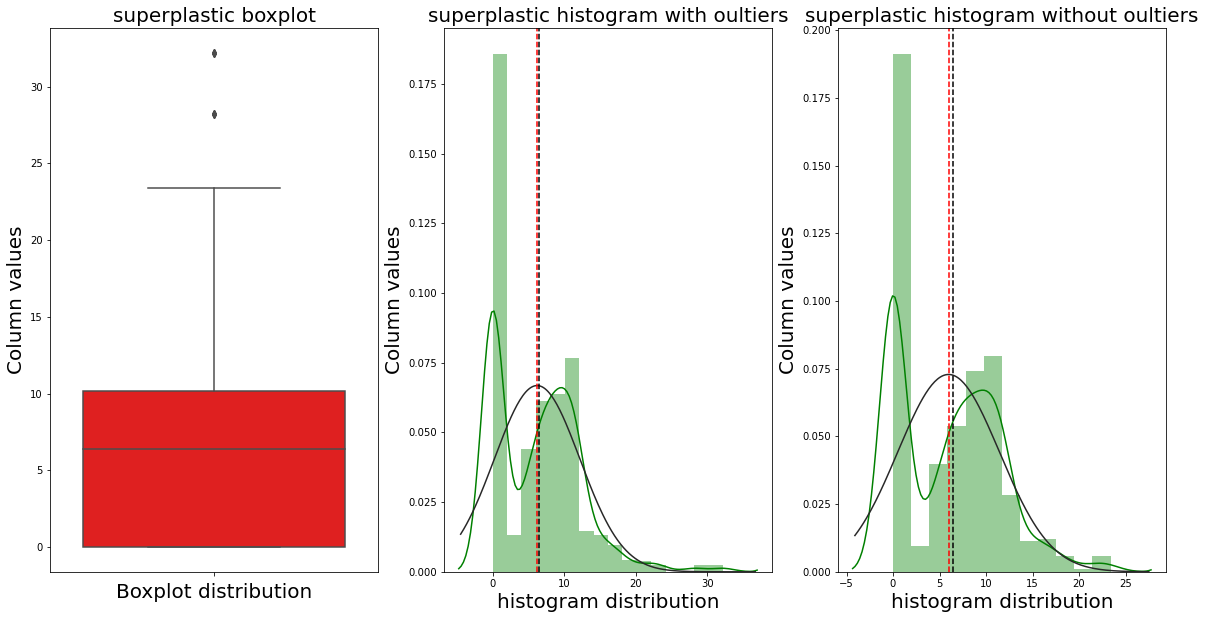

Feature coarseagg does not have any outliers 

-------**********--------


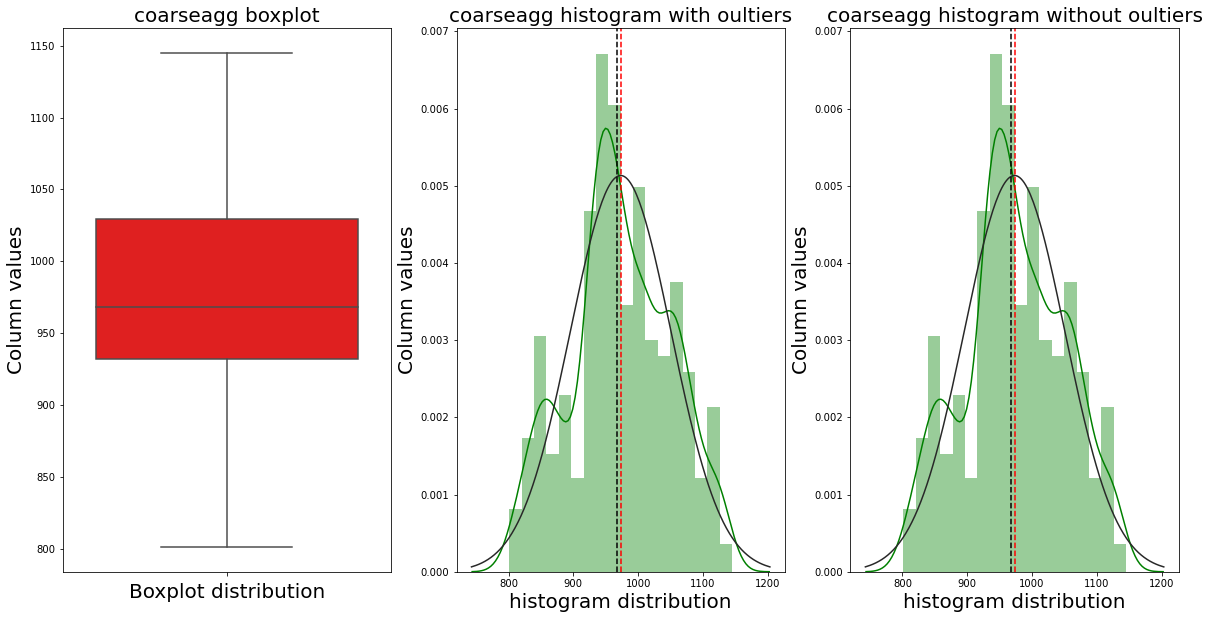

Replacing outliers for fineagg 

Total number of outliers for fineagg are: 5 

Density of the outlier for fineagg is : 0.49 

Outlier for fineagg are [992.6 992.6 992.6 992.6 992.6]


cement  slag  ash  water  superplastic  coarseagg  fineagg  age  strength
129   375.0  93.8  0.0  126.6          23.4      852.1    992.6   91      62.5
447   375.0  93.8  0.0  126.6          23.4      852.1    992.6    7      45.7
504   375.0  93.8  0.0  126.6          23.4      852.1    992.6    3      29.0
584   375.0  93.8  0.0  126.6          23.4      852.1    992.6   56      60.2
857   375.0  93.8  0.0  126.6          23.4      852.1    992.6   28      56.7

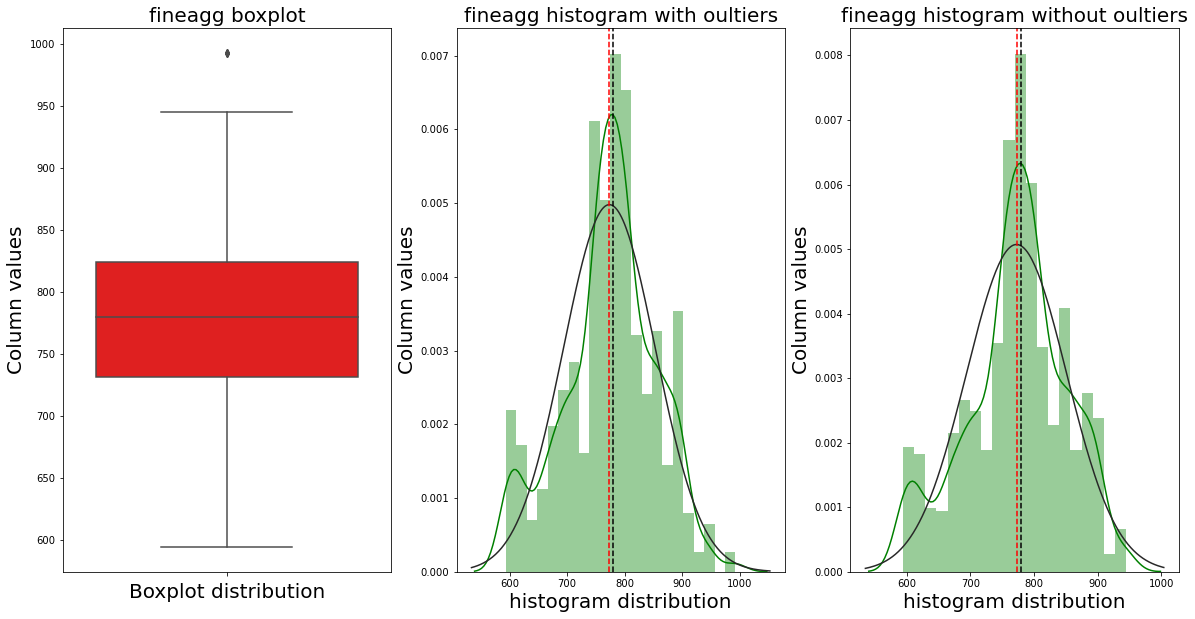

Replacing outliers for age 

Total number of outliers for age are: 59 

Density of the outlier for age is : 5.73 

Outlier for age are [180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 270 270 270 270 270 270 270 270 270 270
 270 270 270 360 360 360 360 360 360 365 365 365 365 365 365 365 365 365
 365 365 365 365 365]


cement   slag  ash  water  superplastic  coarseagg  fineagg  age  \
51     331.0    0.0  0.0  192.0           0.0      978.0    825.0  180   
64     332.5  142.5  0.0  228.0           0.0      932.0    594.0  365   
93     427.5   47.5  0.0  228.0           0.0      932.0    594.0  180   
99     237.5  237.5  0.0  228.0           0.0      932.0    594.0  180   
103    380.0    0.0  0.0  228.0           0.0      932.0    670.0  180   
133    236.0    0.0  0.0  193.0           0.0      968.0    885.0  365   
144    302.0    0.0  0.0  203.0           0.0      974.0    817.0  180   
149    380.0   95.0  0.0  228.0           0.0      932.0    594.0  270   
152    322.0    0.0  0.0  203.0           0.0      974.0    800.0  180   
157    198.6  132.4  0.0  192.0           0.0      978.4    825.5  360   
159    304.0   76.0  0.0  228.0           0.0      932.0    670.0  365   
198    266.0  114.0  0.0  228.0           0.0      932.0    670.0  365   
199    277.0    0.0  0.0  191.0           0.0      968.0    856.0  180   
207    190.0  190.0  0.0  228.0           0.0      932.0    670.0  180   
256    525.0    0.0  0.0  189.0           0.0     1125.0    613.0  270   
262    266.0  114.0  0.0  228.0           0.0      932.0    670.0  270   
270    500.0    0.0  0.0  200.0           0.0     1125.0    613.0  270   
297    475.0    0.0  0.0  228.0           0.0      932.0    594.0  270   
302    342.0   38.0  0.0  228.0           0.0      932.0    670.0  180   
312    236.0    0.0  0.0  193.0           0.0      968.0    885.0  180   
313    540.0    0.0  0.0  173.0           0.0     1125.0    613.0  270   
323    139.6  209.4  0.0  192.0           0.0     1047.0    806.9  360   
359    475.0    0.0  0.0  228.0           0.0      932.0    594.0  180   
361    277.0    0.0  0.0  191.0           0.0      968.0    856.0  360   
370    266.0  114.0  0.0  228.0           0.0      932.0    670.0  180   
393    342.0   38.0  0.0  228.0           0.0      932.0    670.0  365   
448    331.0    0.0  0.0  192.0           0.0      978.0    825.0  360   
465    427.5   47.5  0.0  228.0           0.0      932.0    594.0  365   
484    237.5  237.5  0.0  228.0           0.0      932.0    594.0  365   
539    304.0   76.0  0.0  228.0           0.0      932.0    670.0  180   
570    190.0  190.0  0.0  228.0           0.0      932.0    670.0  270   
581    525.0    0.0  0.0  189.0           0.0     1125.0    613.0  180   
594    339.0    0.0  0.0  197.0           0.0      968.0    781.0  180   
601    339.0    0.0  0.0  197.0           0.0      968.0    781.0  365   
620    332.5  142.5  0.0  228.0           0.0      932.0    594.0  180   
622    380.0   95.0  0.0  228.0           0.0      932.0    594.0  180   
623    380.0    0.0  0.0  228.0           0.0      932.0    670.0  270   
632    304.0   76.0  0.0  228.0           0.0      932.0    670.0  270   
642    198.6  132.4  0.0  192.0           0.0      978.4    825.5  180   
696    307.0    0.0  0.0  193.0           0.0      968.0    812.0  180   
713    190.0  190.0  0.0  228.0           0.0      932.0    670.0  365   
720    380.0   95.0  0.0  228.0           0.0      932.0    594.0  365   
721    500.0    0.0  0.0  200.0           0.0     1125.0    613.0  180   
754    254.0    0.0  0.0  198.0           0.0      968.0    863.0  365   
755    349.0    0.0  0.0  192.0           0.0     1047.0    806.0  360   
776    540.0    0.0  0.0  173.0           0.0     1125.0    613.0  180   
850    427.5   47.5  0.0  228.0           0.0      932.0    594.0  270   
861    310.0    0.0  0.0  192.0           0.0      970.0    850.0  180   
878    237.5  237.5  0.0  228.0           0.0      932.0    594.0  270   
900    254.0    0.0  0.0  198.0           0.0      968.0    863.0  180   
901    475.0    0.0  0.0  228.0           0.0      932.0    594.0  365   
919    310.0    0.0  0.0  192.0           0.0      970.0    850.0  360   
951    332.5  142.5  0.0  228.0           0.0      932.0    594.0  270   
957    307

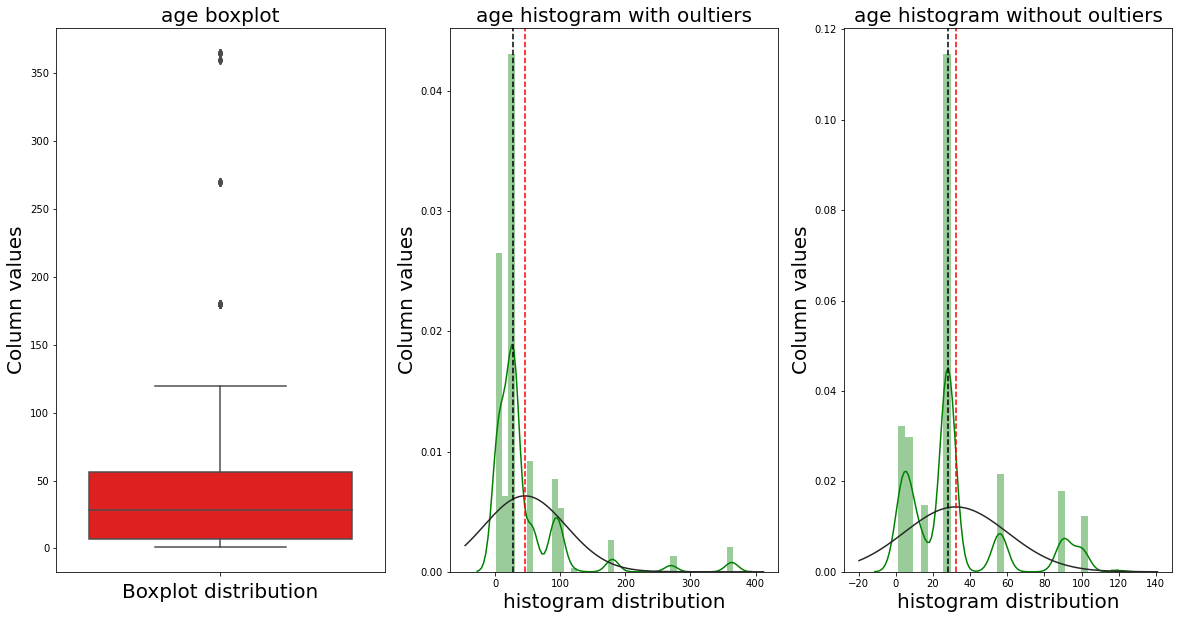

Replacing outliers for strength 

Total number of outliers for strength are: 4 

Density of the outlier for strength is : 0.39 

Outlier for strength are [79.99 80.2  81.75 82.6 ]


cement   slag  ash  water  superplastic  coarseagg  fineagg   age  \
192    315.0  137.0  0.0  145.0           5.9     1130.0    745.0  28.0   
732    540.0    0.0  0.0  162.0           2.5     1040.0    676.0  28.0   
950    389.9  189.0  0.0  145.9          22.0      944.7    755.8  91.0   
1003   323.7  282.8  0.0  183.8          10.3      942.7    659.9  56.0   

      strength  
192      81.75  
732      79.99  
950      82.60  
1003     80.20

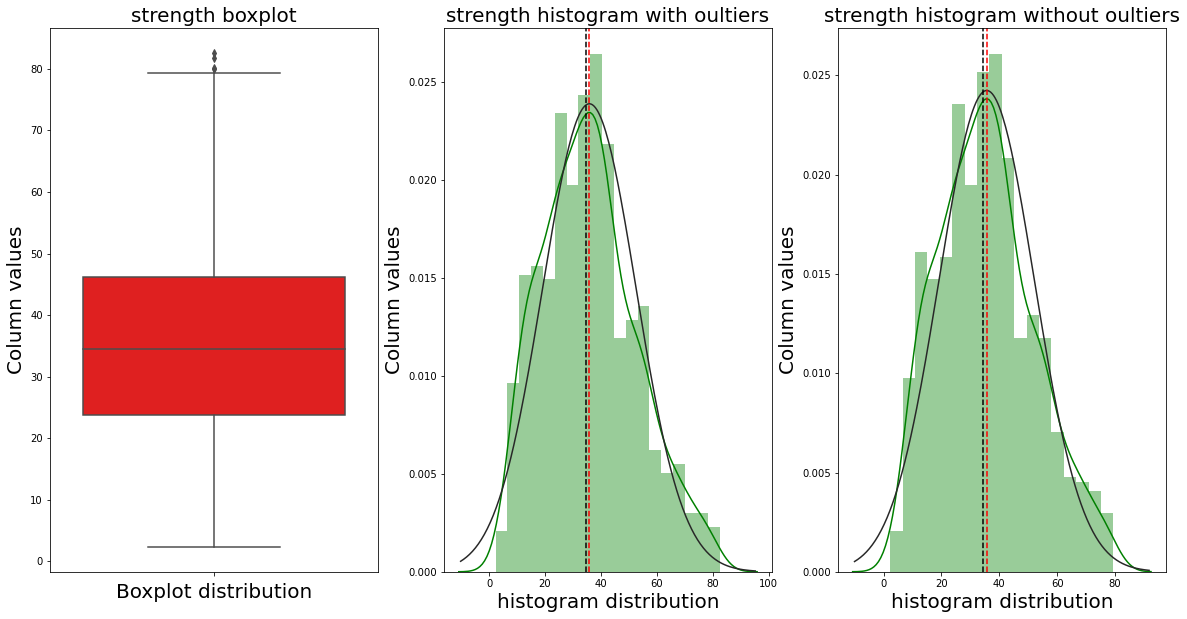

In [9]:
for col in list(df.columns):
    odtplot(df,col)

## Custom summary after data treatment

In [10]:
CustomSummary(df)

Count Datatype      SD       Var     Min      Q1    Mean  \
FeatureName                                                              
cement         1030  float64  104.51  10921.58  102.00  192.38  281.17   
slag           1030  float64   85.38   7290.50    0.00    0.00   73.24   
ash            1030  float64   64.00   4095.62    0.00    0.00   54.19   
water          1030  float64   20.60    424.49  126.60  164.90  181.65   
superplastic   1030  float64    5.48     30.00    0.00    0.00    5.97   
coarseagg      1030  float64   77.75   6045.68  801.00  932.00  972.92   
fineagg        1030  float64   78.70   6194.20  594.00  730.95  772.55   
age            1030  float64   27.80    773.05    1.00    7.00   32.26   
strength       1030  float64   16.46    271.07    2.33   23.71   35.64   

              Median       Q3     Max   Range     IQR  Kurtosis  Skewness  \
FeatureName                                                                 
cement        272.90   350.00   540.0  438.00  157.62     -0.52      0.51   
slag           22.00   142.73   342.1  342.10  142.73     -0.62      0.78   
ash             0.00   118.30   200.1  200.10  118.30     -1.33      0.54   
water         185.00   192.00   228.0  101.40   27.10     -0.04      0.09   
superplastic    6.40    10.07    23.4   23.40   10.07     -0.44      0.47   
coarseagg     968.00  1029.40  1145.0  344.00   97.40     -0.60     -0.04   
fineagg       779.40   822.20   945.0  351.00   91.25     -0.19     -0.33   
age            28.00    28.00   120.0  119.00   21.00      0.79      1.29   
strength       34.42    45.81    79.4   77.07   22.10     -0.36      0.39   

                         Skewness Comment Outlier Comment  
FeatureName                                                
cement        Moderatey Positively Skewed     No Outliers  
slag          Moderatey Positively Skewed     No Outliers  
ash           Moderatey Positively Skewed     No Outliers  
water          Fairly Symmetric(Positive)     No Outliers  
superplastic   Fairly Symmetric(Positive)     No Outliers  
coarseagg      Fairly Symmetric(Negative)     No Outliers  
fineagg        Fairly Symmetric(Negative)     Has Outlier  
age              Highly Positively Skewed     Has Outlier  
strength       Fairly Symmetric(Positive)     Has Outlier

In [11]:
CustomSummary(df2)

Count Datatype      SD       Var     Min      Q1    Mean  \
FeatureName                                                              
cement         1030  float64  104.51  10921.58  102.00  192.38  281.17   
slag           1030  float64   86.28   7444.12    0.00    0.00   73.90   
ash            1030  float64   64.00   4095.62    0.00    0.00   54.19   
water          1030  float64   21.35    456.00  121.80  164.90  181.57   
superplastic   1030  float64    5.97     35.69    0.00    0.00    6.20   
coarseagg      1030  float64   77.75   6045.68  801.00  932.00  972.92   
fineagg        1030  float64   80.18   6428.19  594.00  730.95  773.58   
age            1030    int64   63.17   3990.44    1.00    7.00   45.66   
strength       1030  float64   16.71    279.08    2.33   23.71   35.82   

              Median       Q3     Max   Range     IQR  Kurtosis  Skewness  \
FeatureName                                                                 
cement        272.90   350.00   540.0  438.00  157.62     -0.52      0.51   
slag           22.00   142.95   359.4  359.40  142.95     -0.51      0.80   
ash             0.00   118.30   200.1  200.10  118.30     -1.33      0.54   
water         185.00   192.00   247.0  125.20   27.10      0.12      0.07   
superplastic    6.40    10.20    32.2   32.20   10.20      1.41      0.91   
coarseagg     968.00  1029.40  1145.0  344.00   97.40     -0.60     -0.04   
fineagg       779.50   824.00   992.6  398.60   93.05     -0.10     -0.25   
age            28.00    56.00   365.0  364.00   49.00     12.17      3.27   
strength       34.45    46.14    82.6   80.27   22.43     -0.31      0.42   

                         Skewness Comment Outlier Comment  
FeatureName                                                
cement        Moderatey Positively Skewed     No Outliers  
slag          Moderatey Positively Skewed     Has Outlier  
ash           Moderatey Positively Skewed     No Outliers  
water          Fairly Symmetric(Positive)     Has Outlier  
superplastic  Moderatey Positively Skewed     Has Outlier  
coarseagg      Fairly Symmetric(Negative)     No Outliers  
fineagg        Fairly Symmetric(Negative)     Has Outlier  
age              Highly Positively Skewed     Has Outlier  
strength       Fairly Symmetric(Positive)     Has Outlier

In [12]:
x = df.drop('strength', axis=1)
y = df[['strength']]

In [13]:
x.head()

cement   slag    ash  water  superplastic  coarseagg  fineagg   age
0   141.3  212.0    0.0  203.5           0.0      971.8    748.5  28.0
1   168.9   42.2  124.3  158.3          10.8     1080.8    796.2  14.0
2   250.0    0.0   95.7  187.4           5.5      956.9    861.2  28.0
3   266.0  114.0    0.0  228.0           0.0      932.0    670.0  28.0
4   154.8  183.4    0.0  193.3           9.1     1047.4    696.7  28.0

In [14]:
y.head()

strength
0     29.89
1     23.51
2     29.22
3     45.85
4     18.29

## Feature Interation

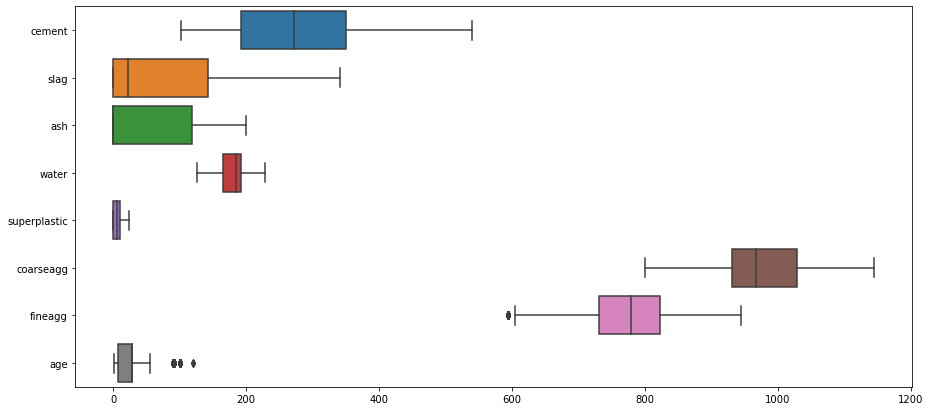

In [15]:
## Check distribution
fig = plt.figure(figsize=(15,7))
ax = sns.boxplot(data=x,orient='h')
# Note : for categorical variables boxplot cant be used...so use column graph

In [16]:
## Feature interation using pairplots

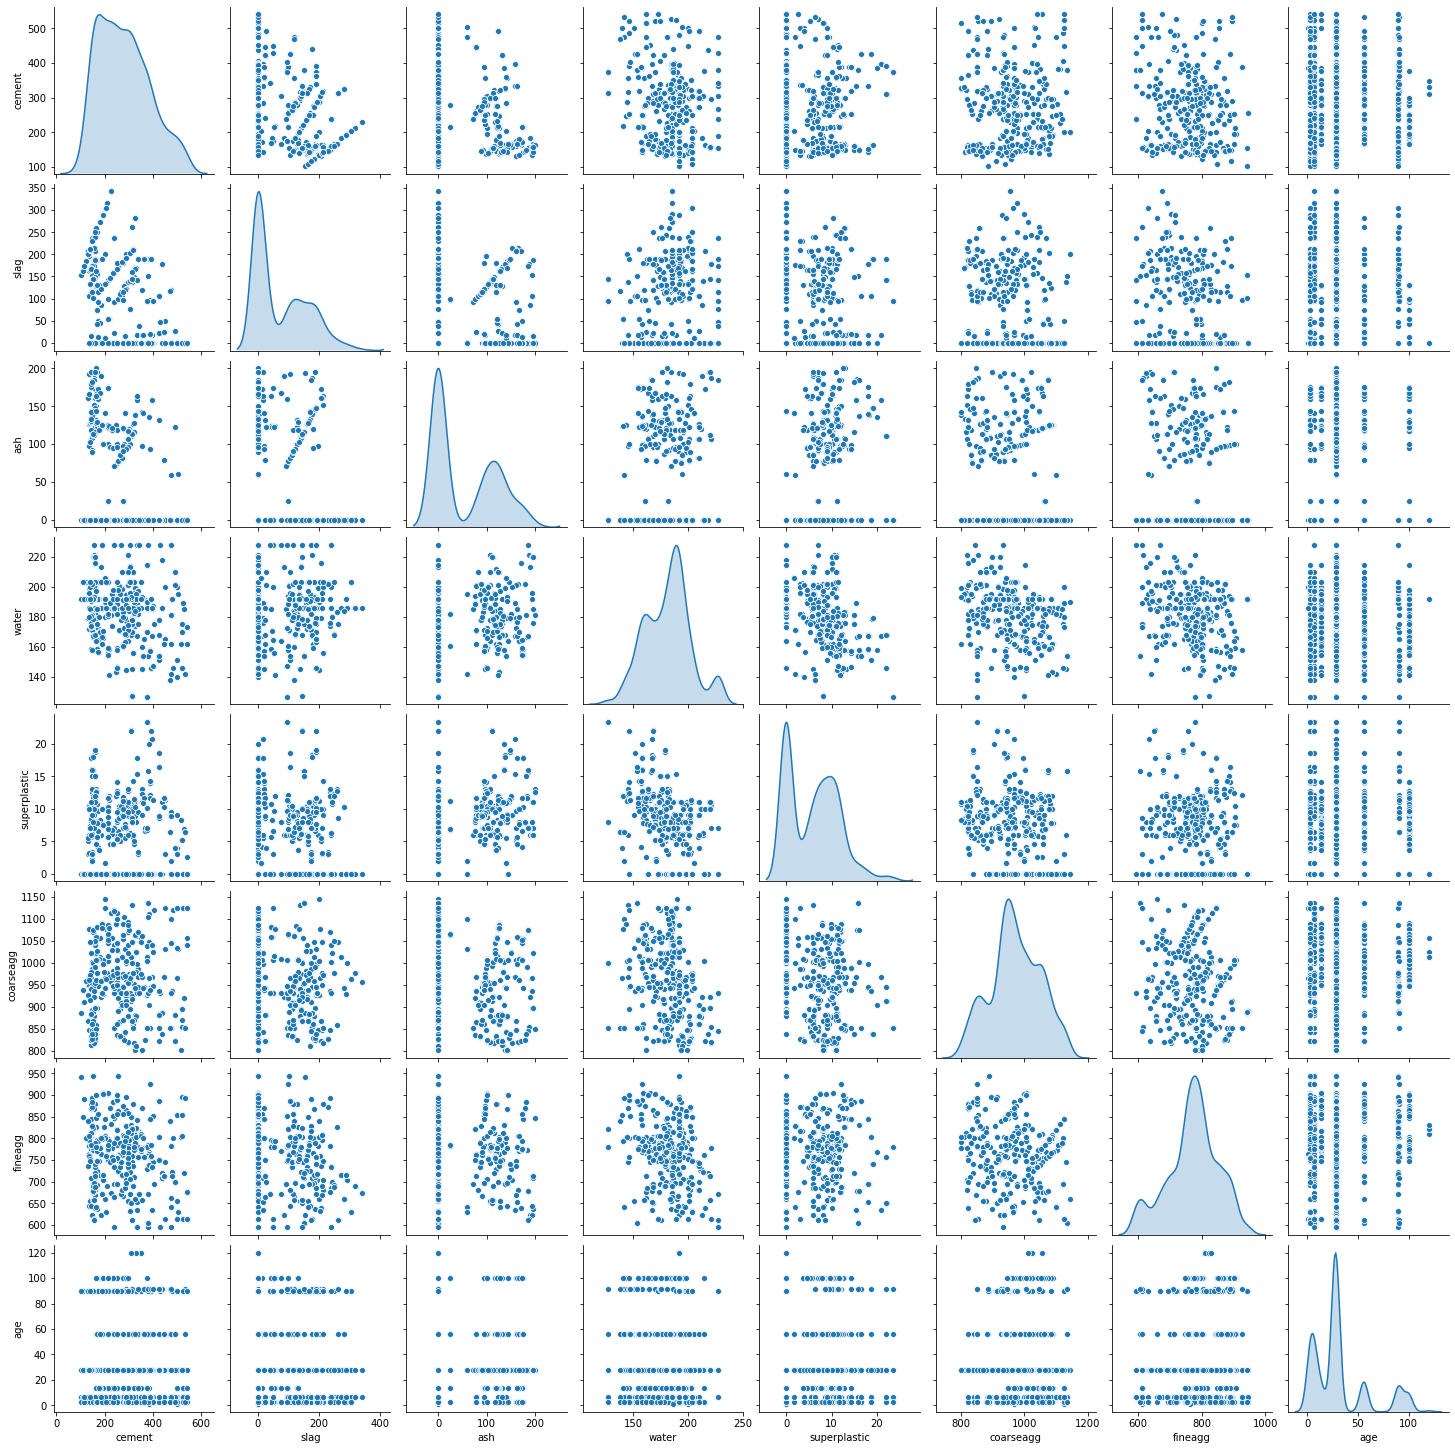

In [17]:
sns.pairplot(x,diag_kind='kde') # scatter plot with each and every feature

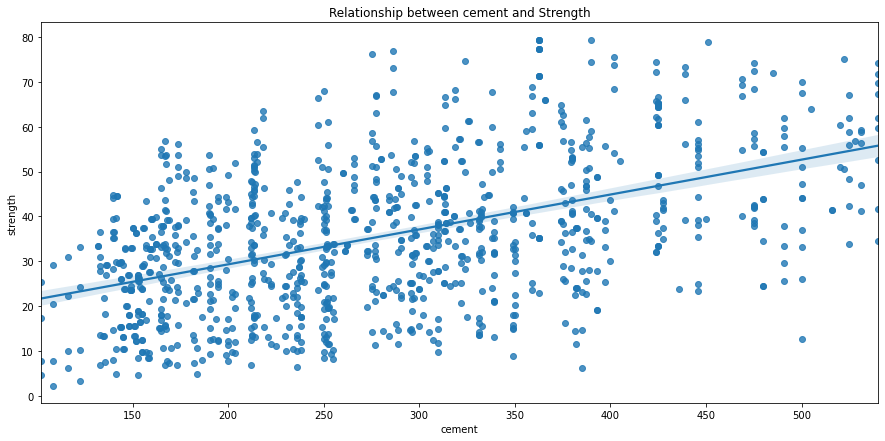

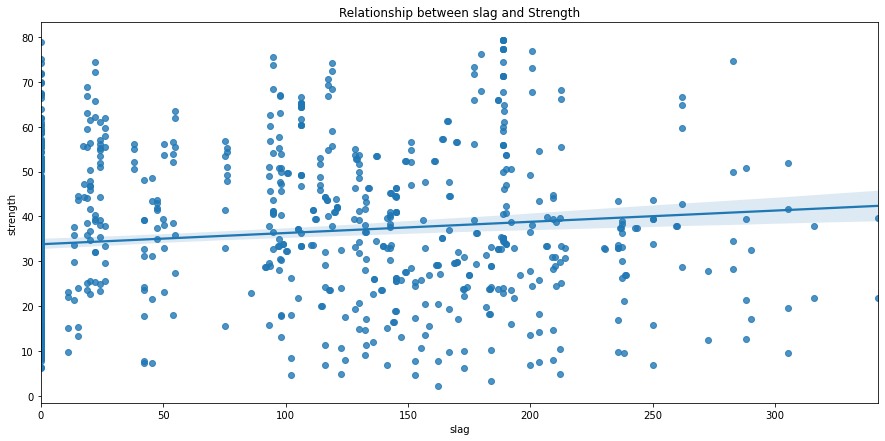

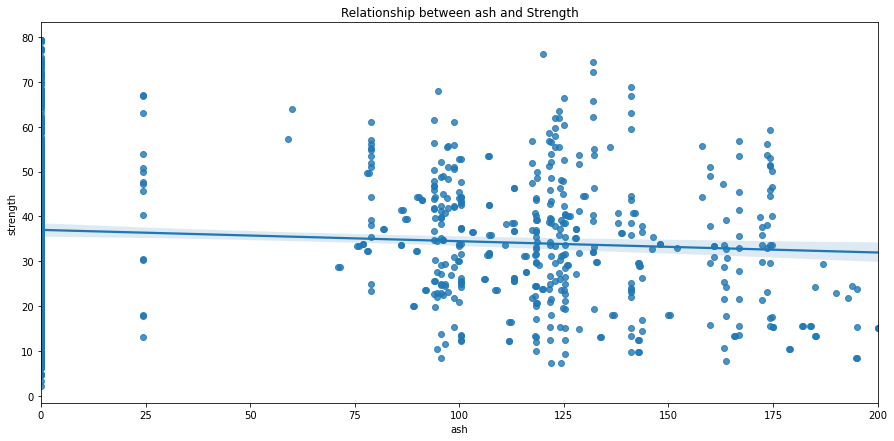

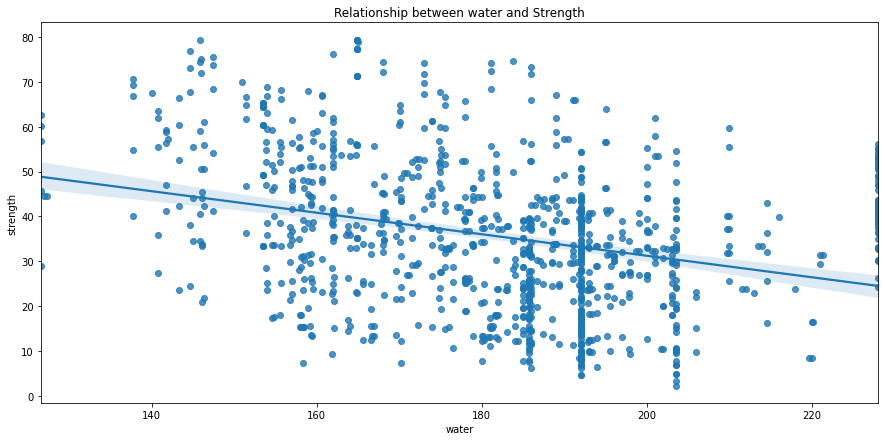

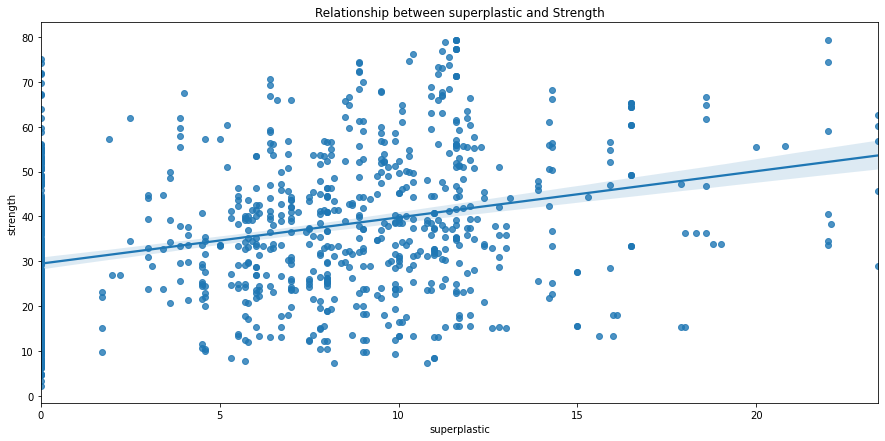

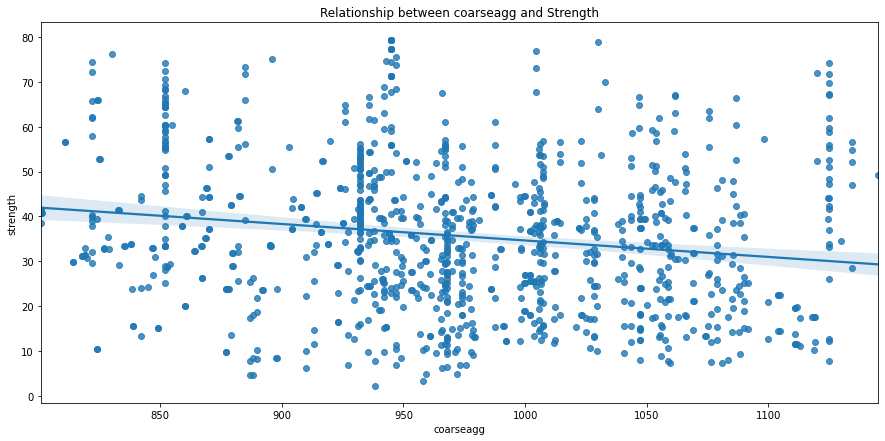

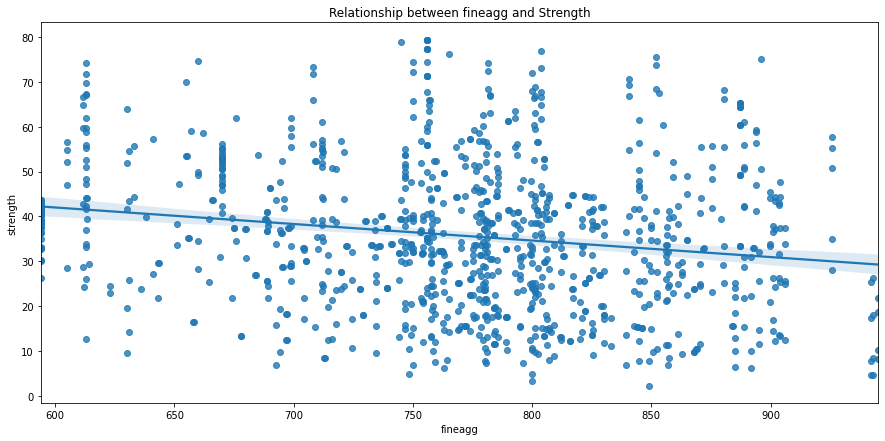

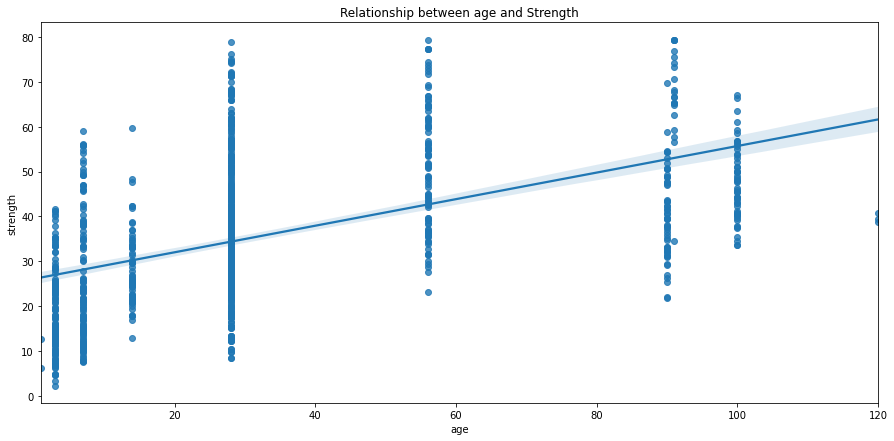

In [18]:
## Multivariate analysis
for col in list(df.columns):
    if col != 'strength':
        fig,ax1 = plt.subplots(figsize=(15,7),sharex=False) # sharex is false then have single graph
        sns.regplot(x=df[col],y=df['strength'],ax=ax1).set_title(f'Relationship between {col} and Strength')

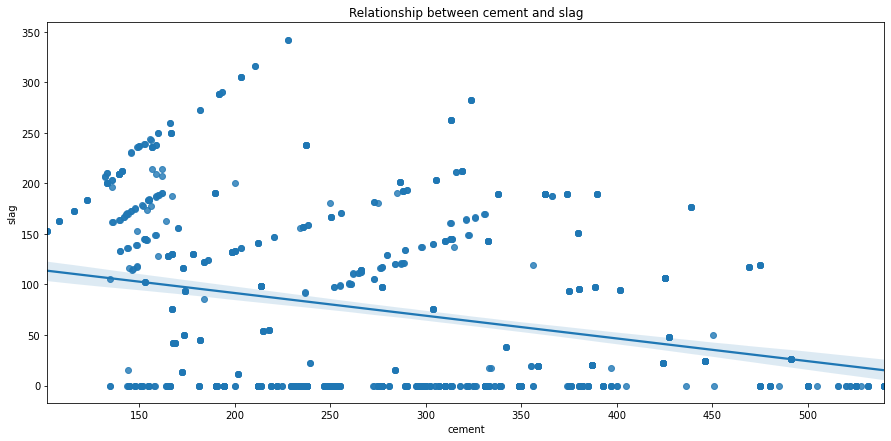

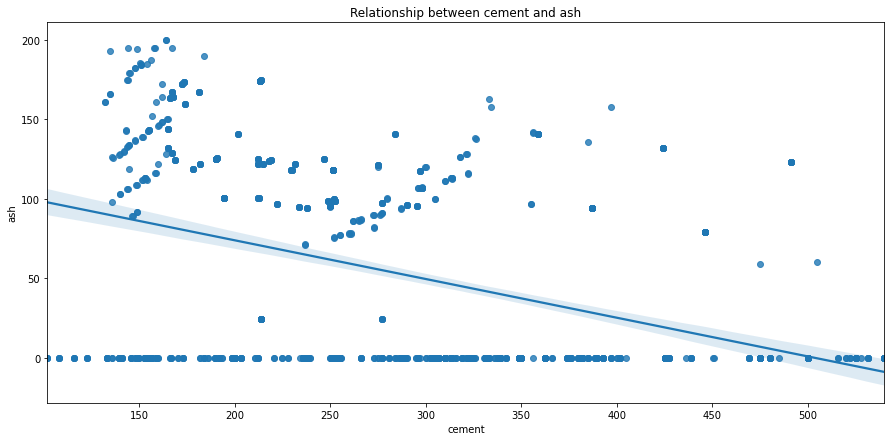

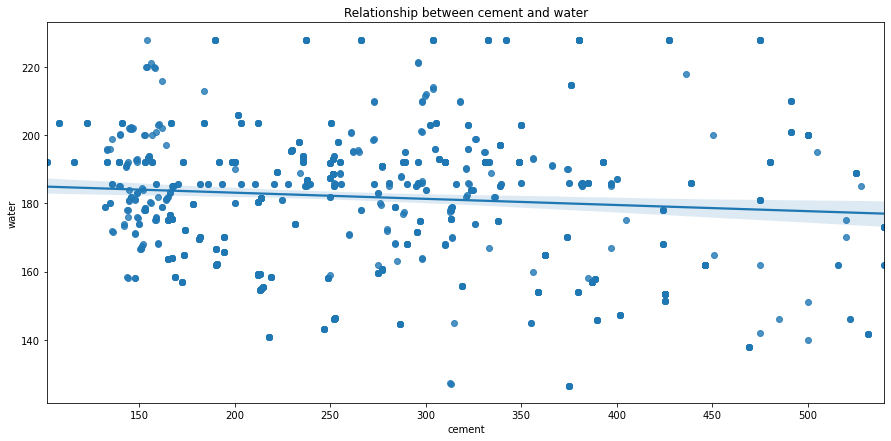

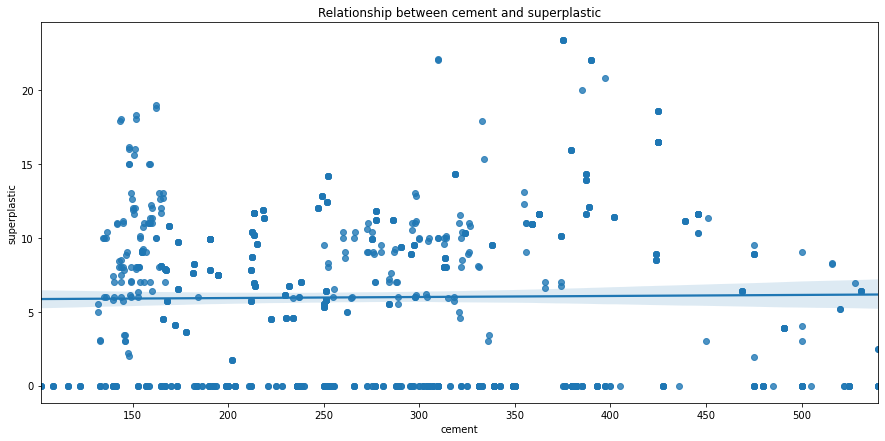

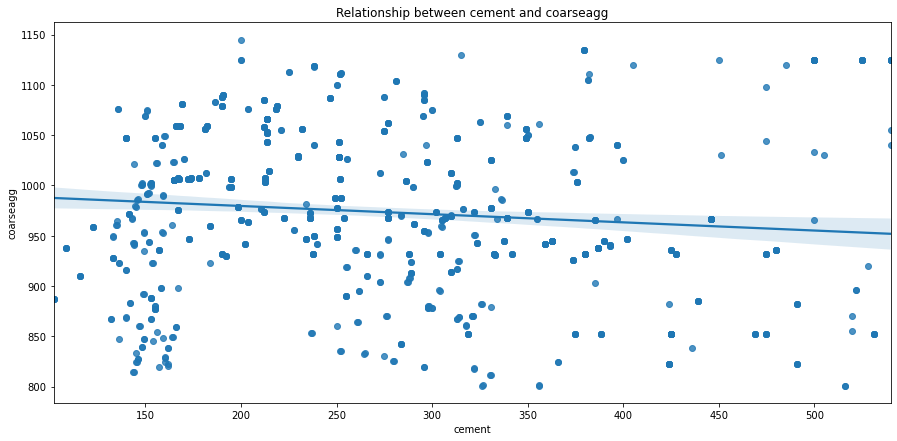

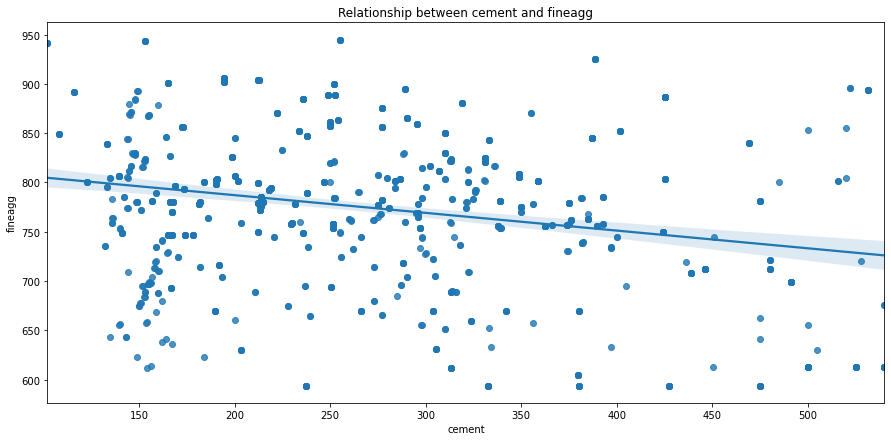

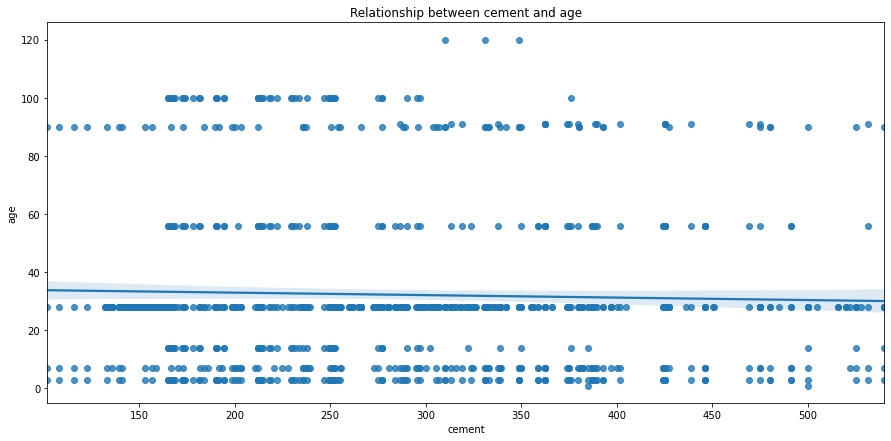

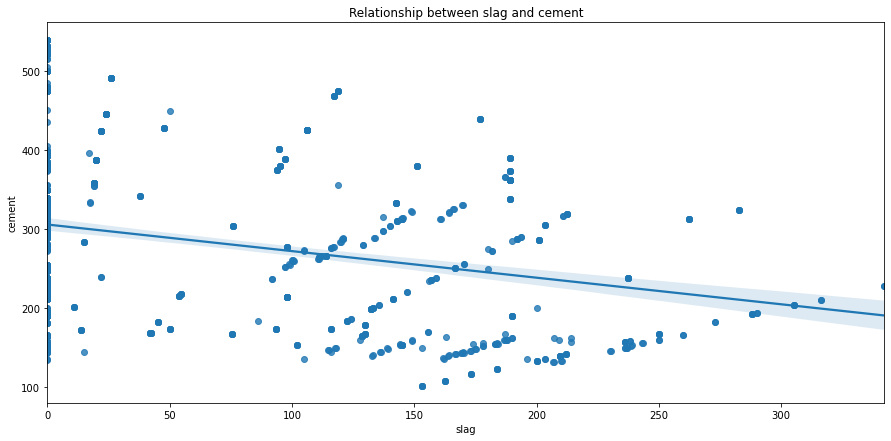

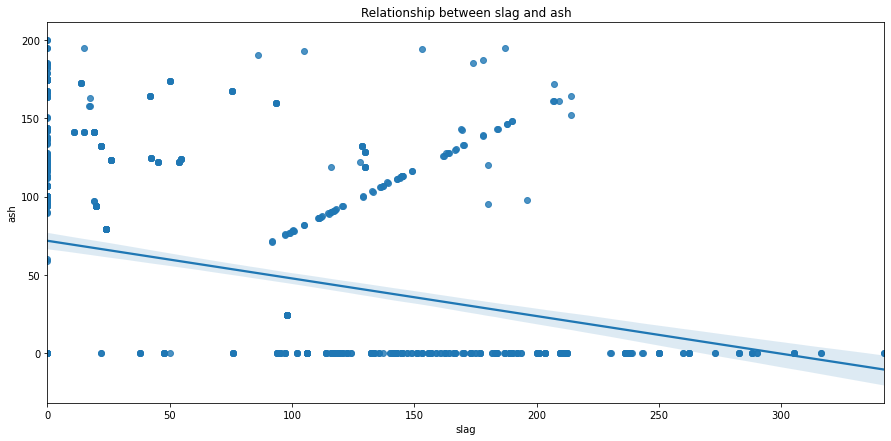

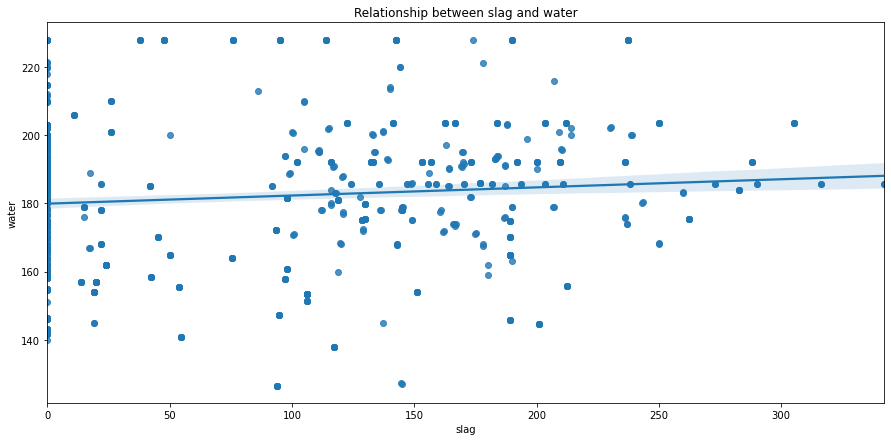

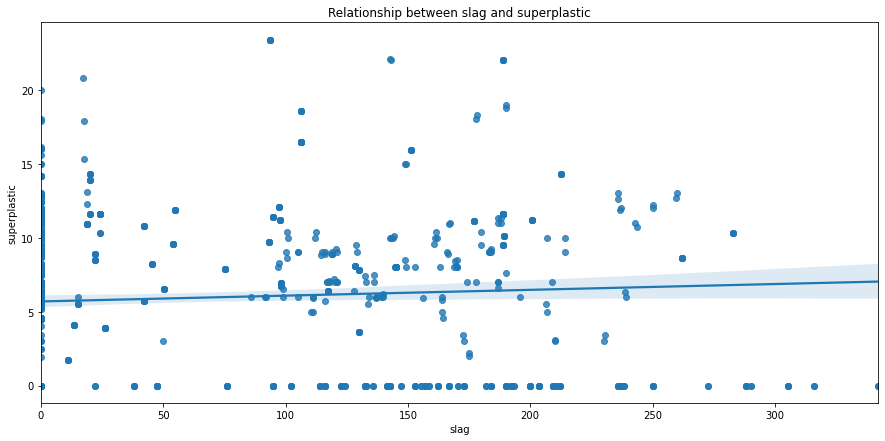

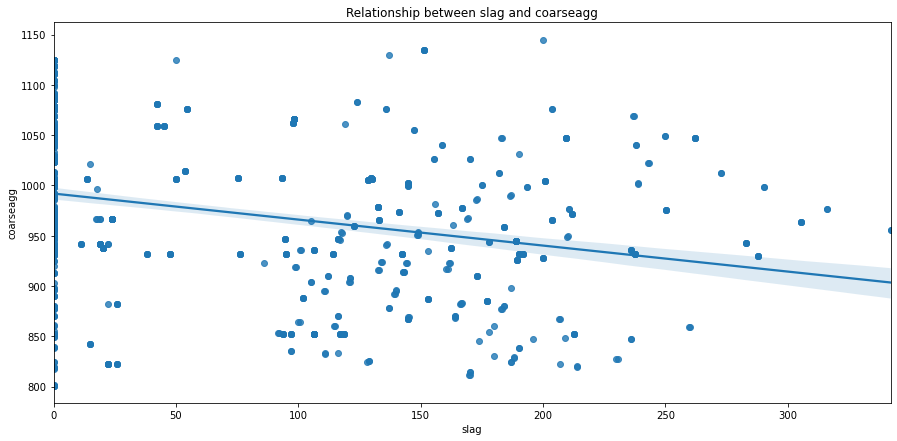

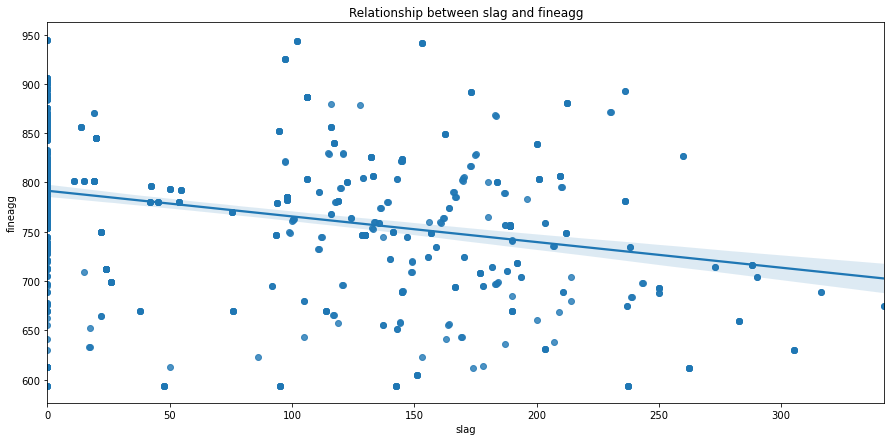

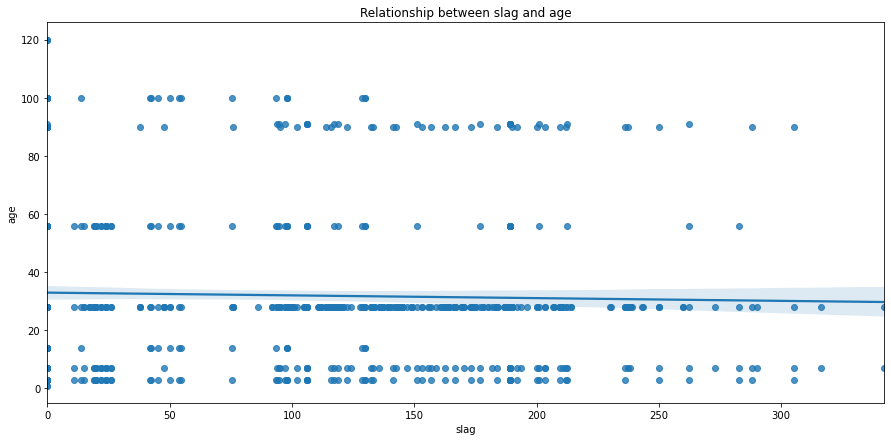

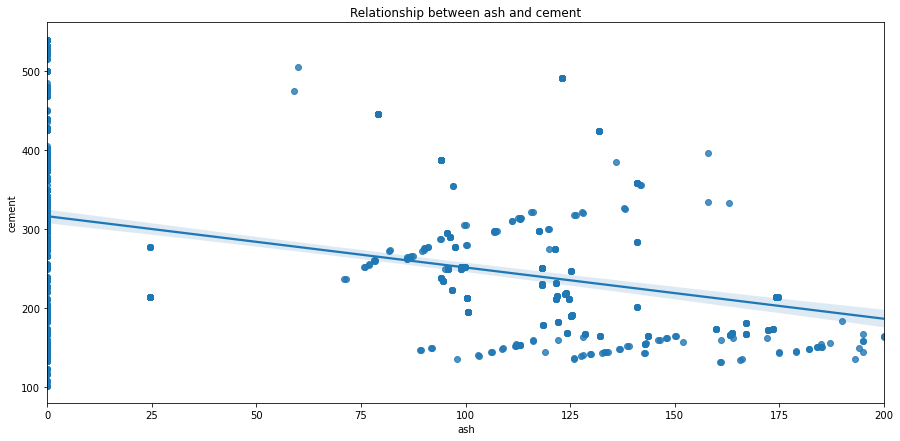

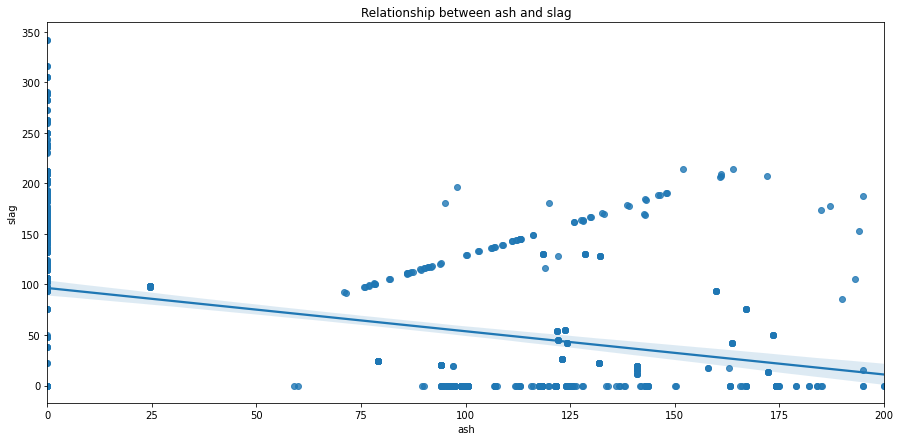

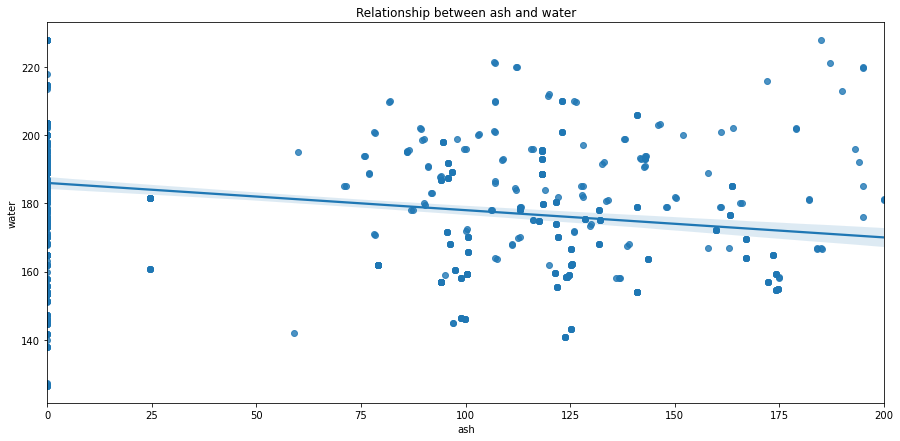

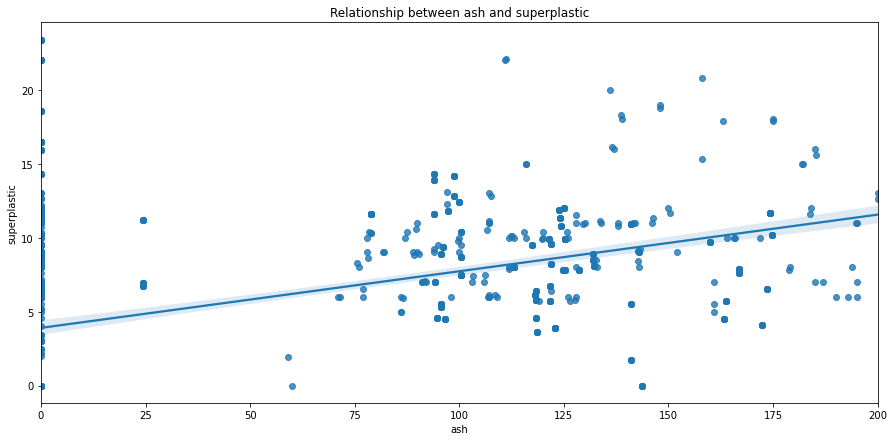

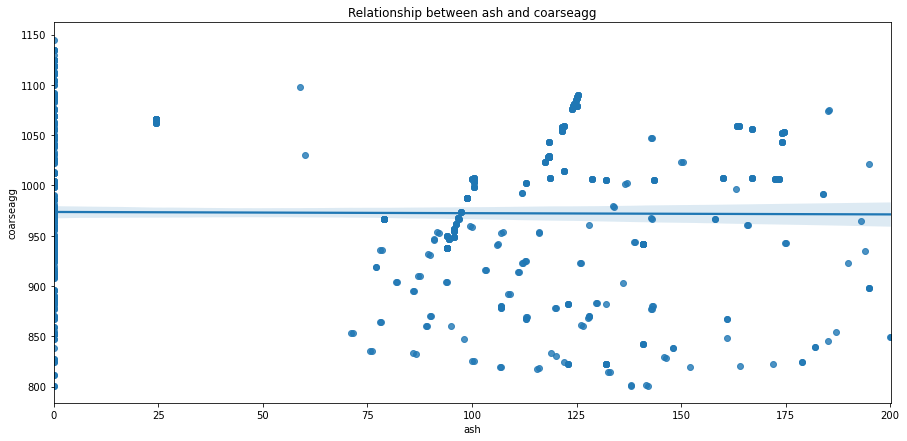

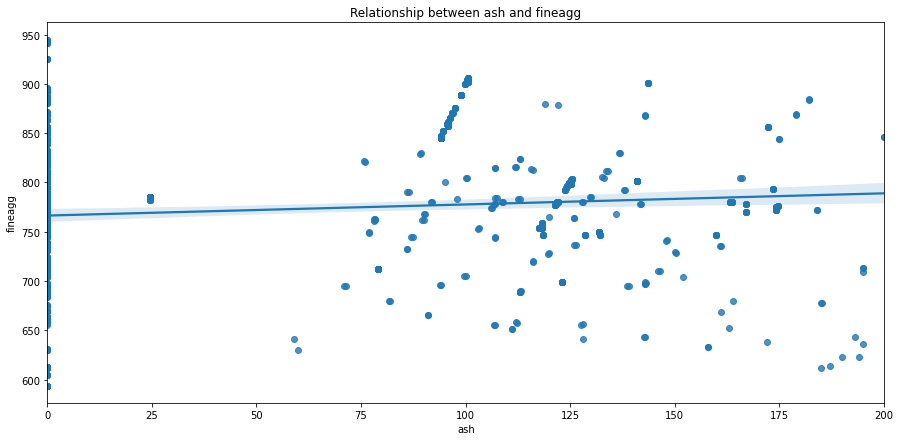

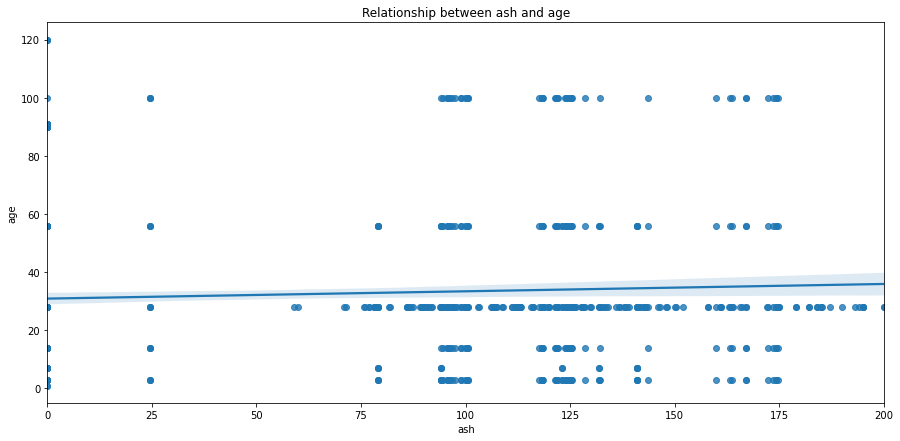

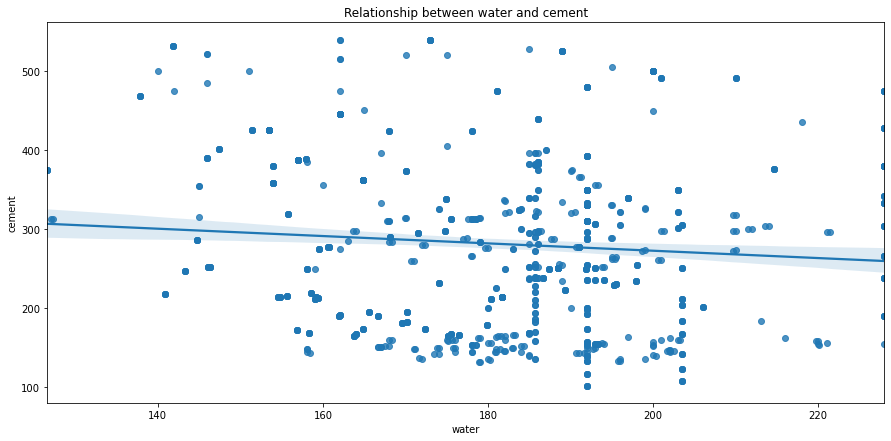

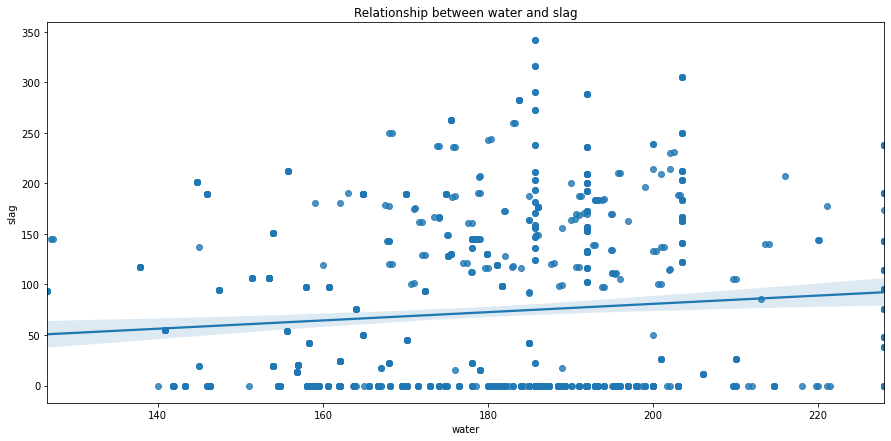

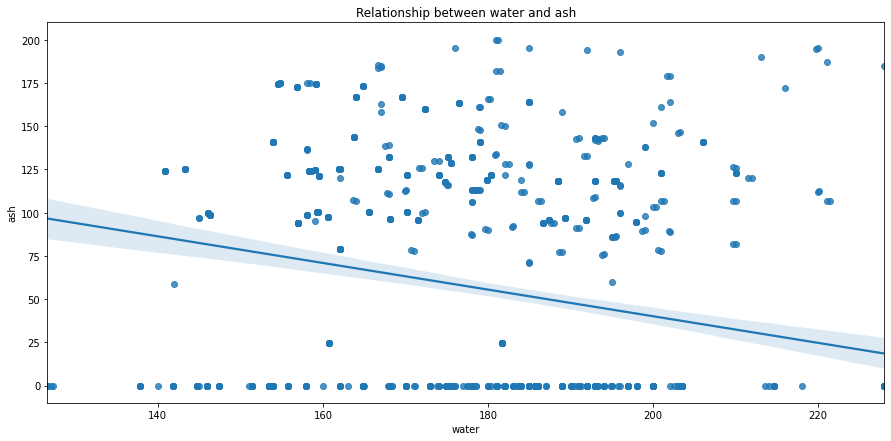

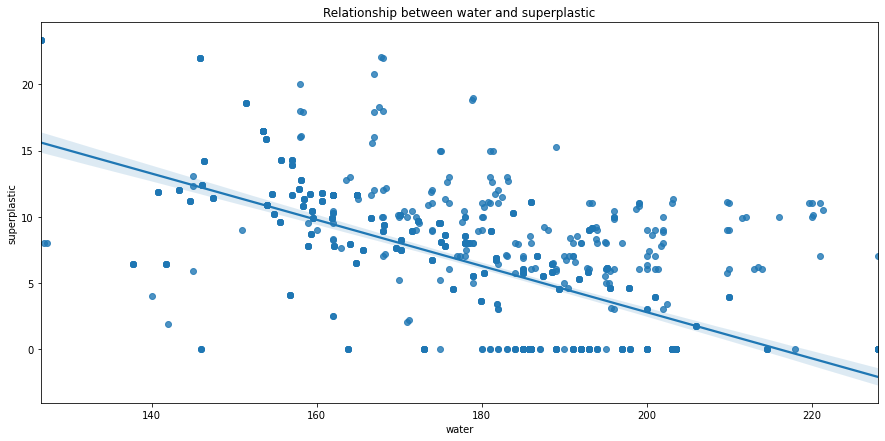

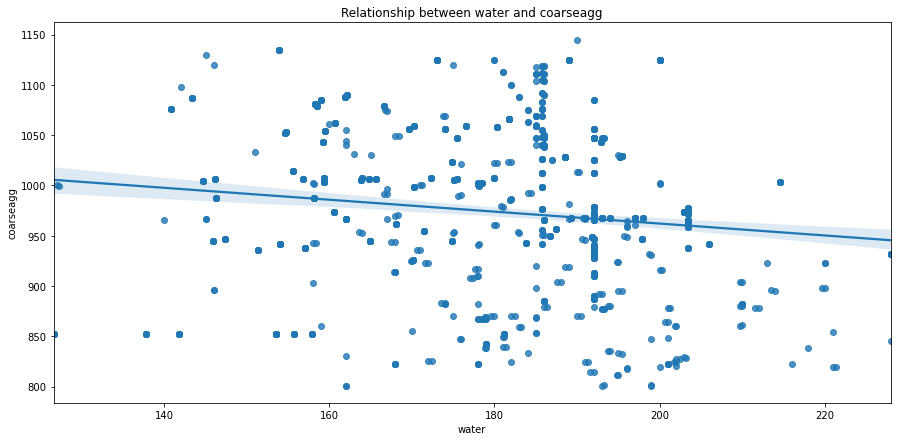

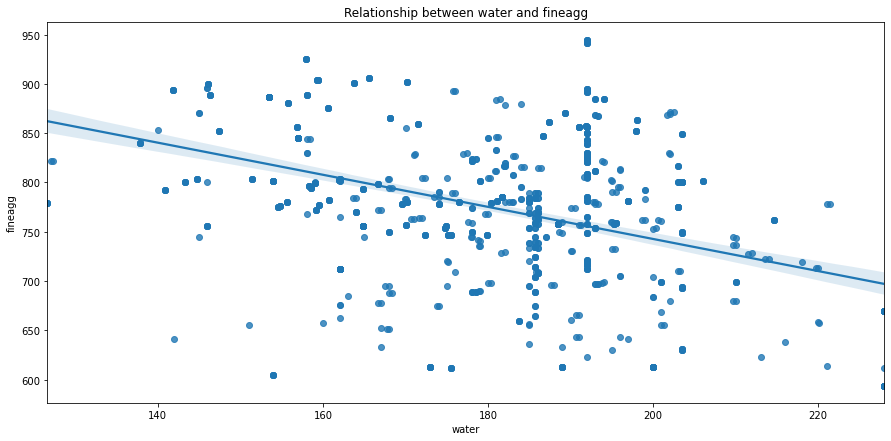

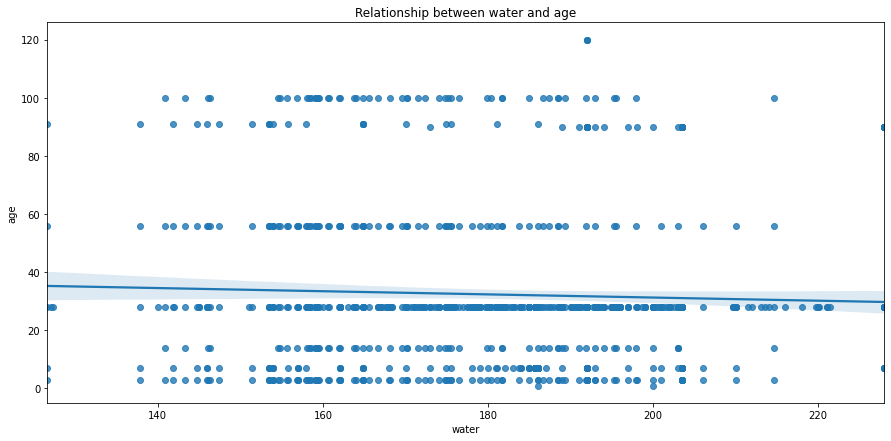

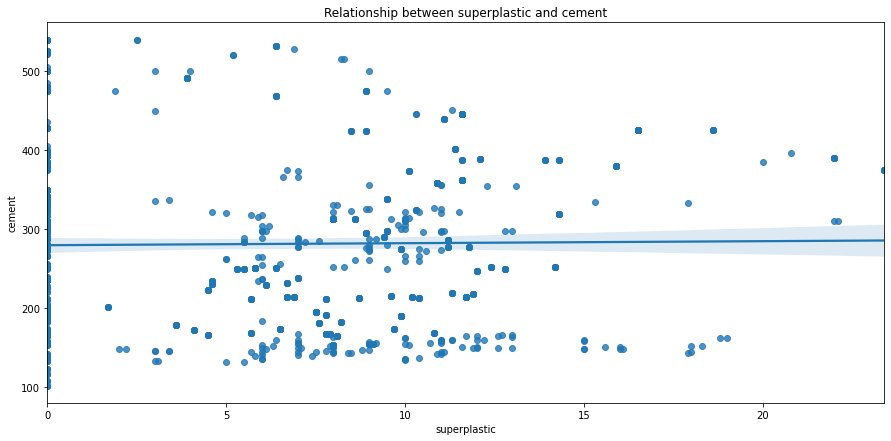

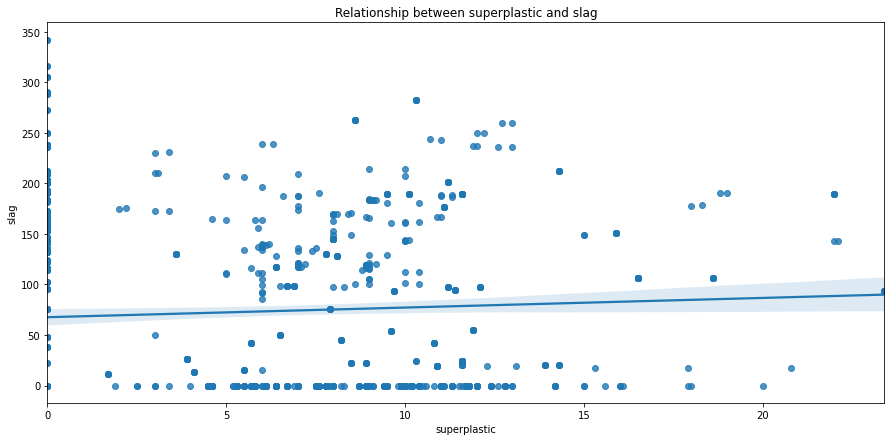

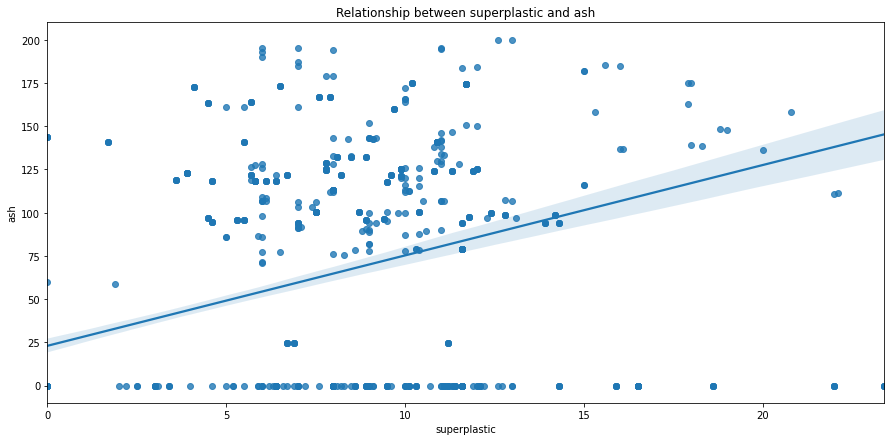

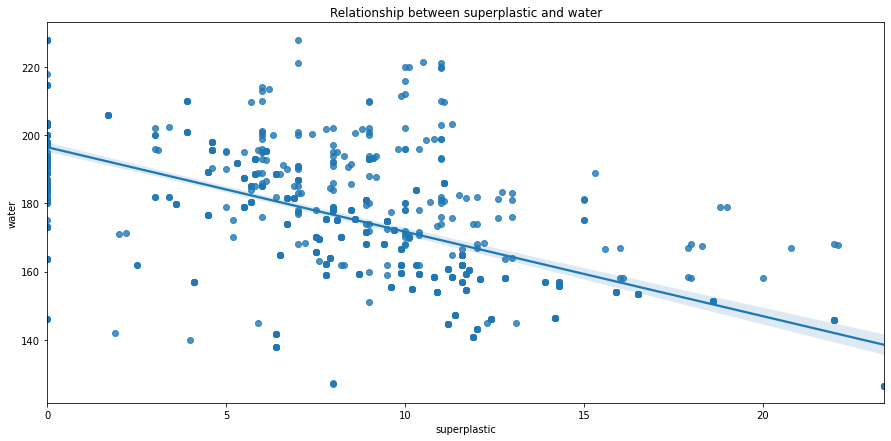

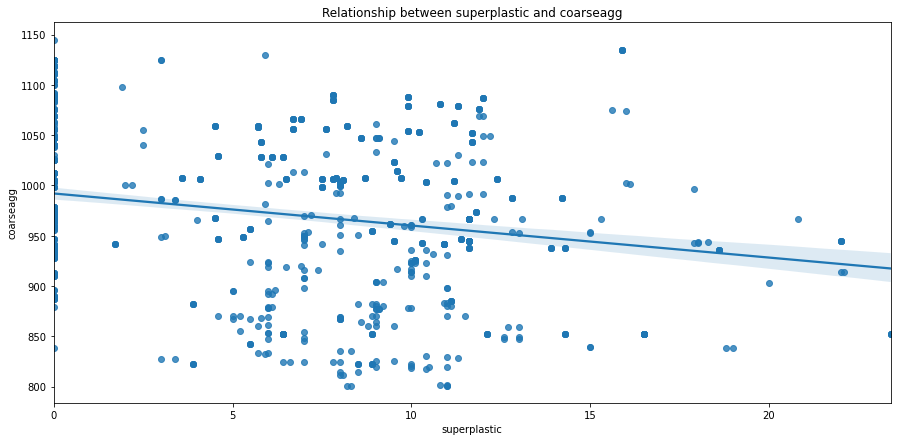

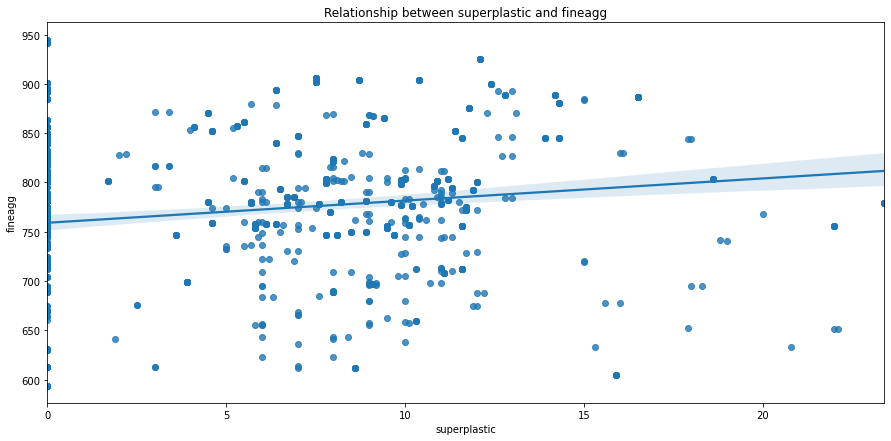

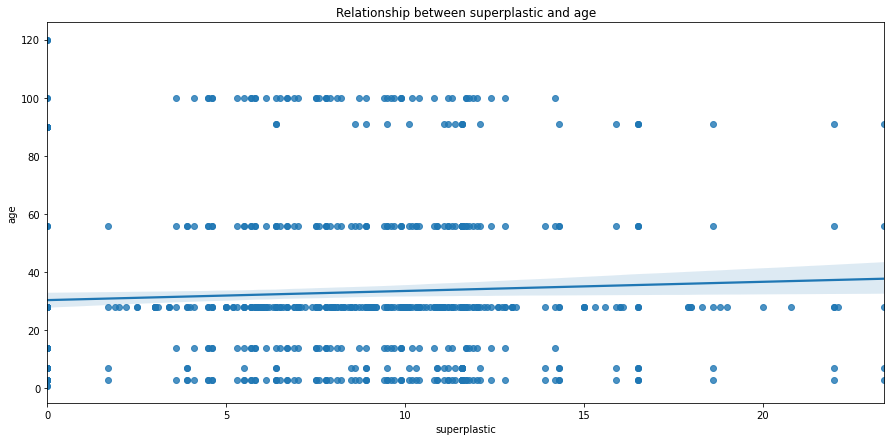

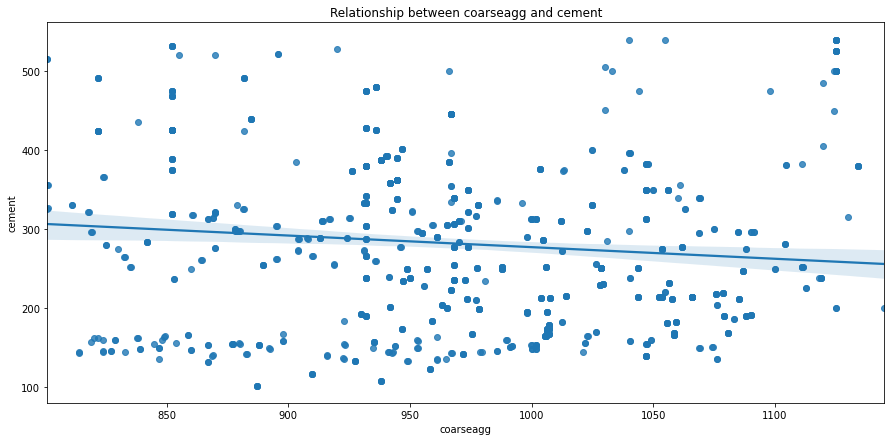

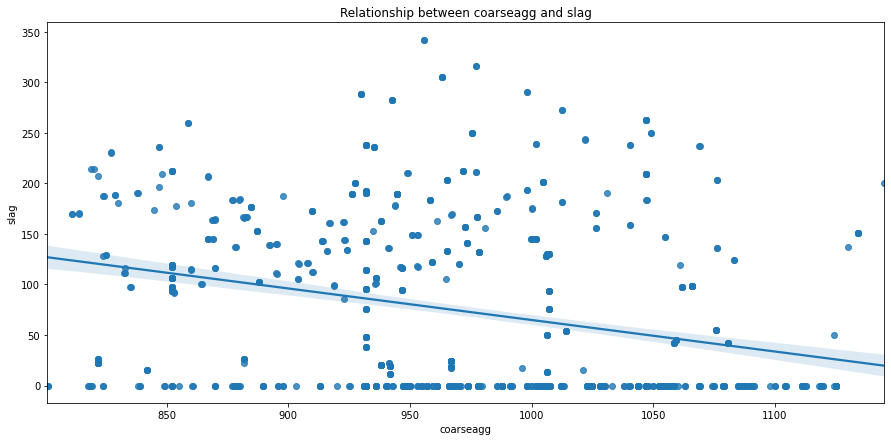

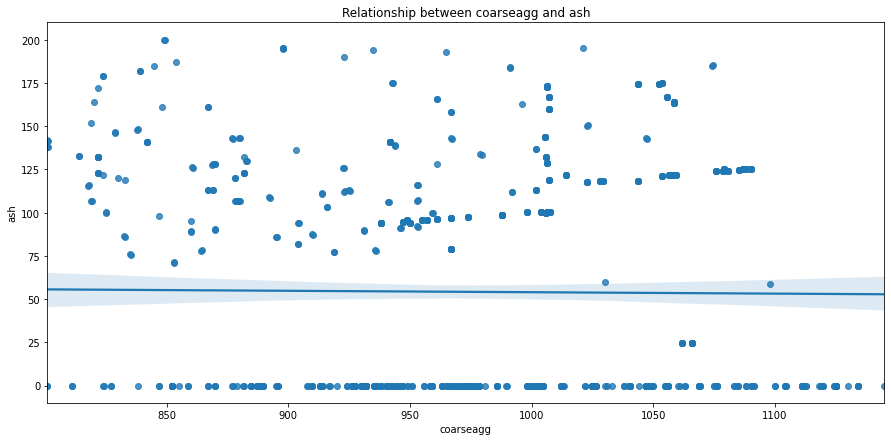

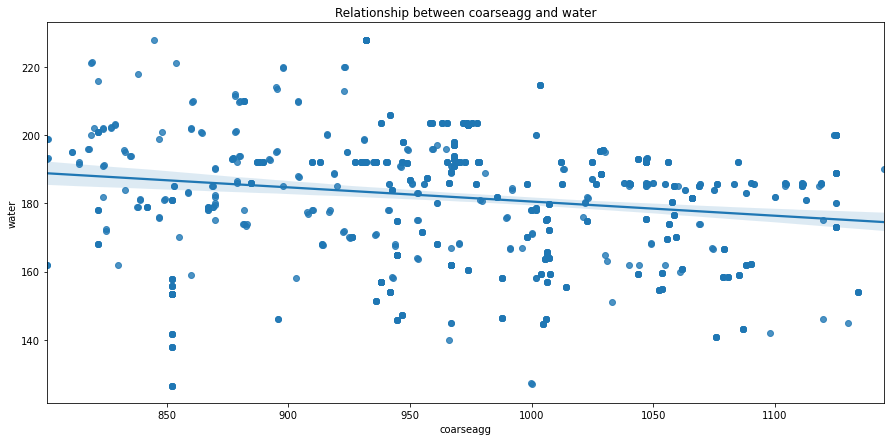

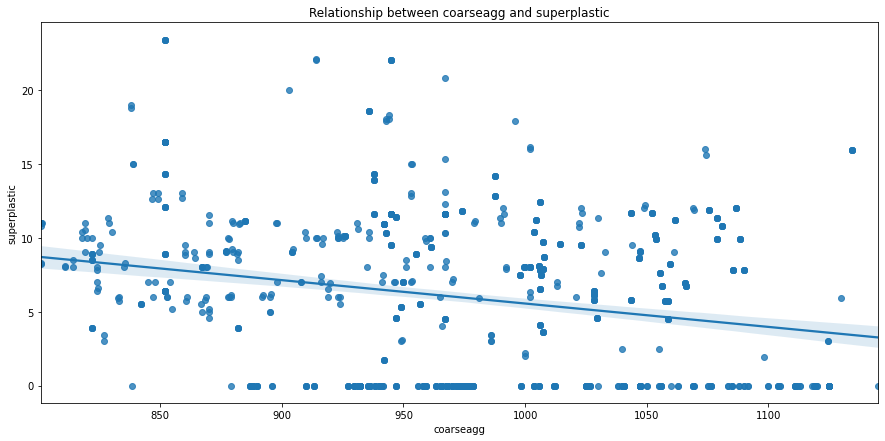

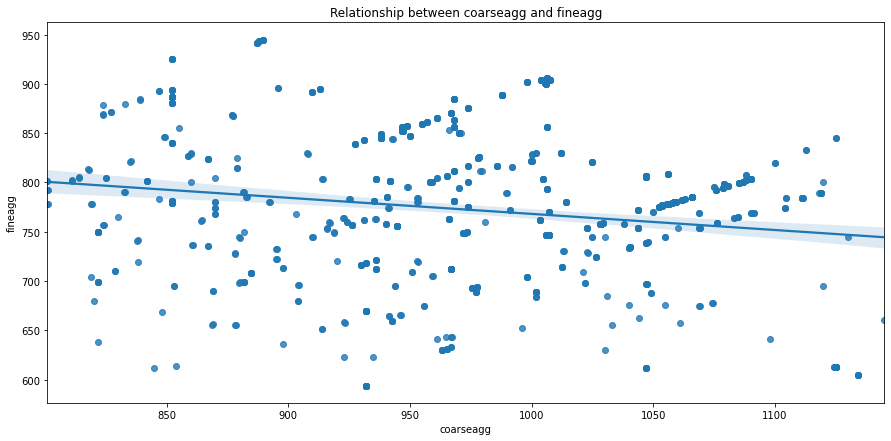

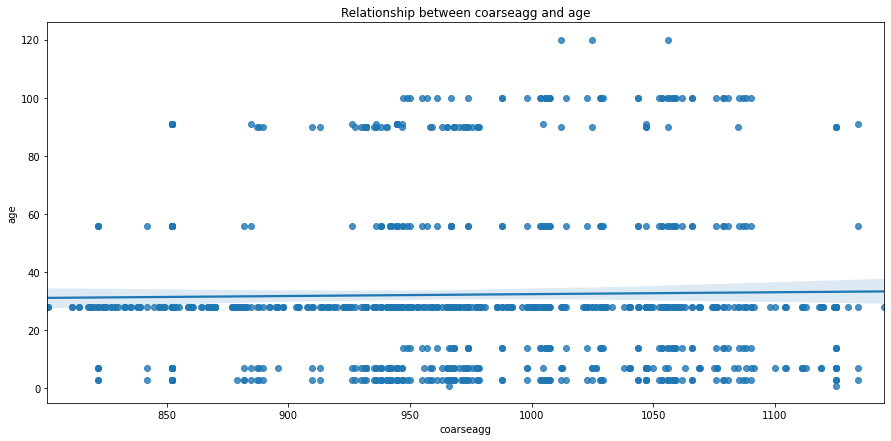

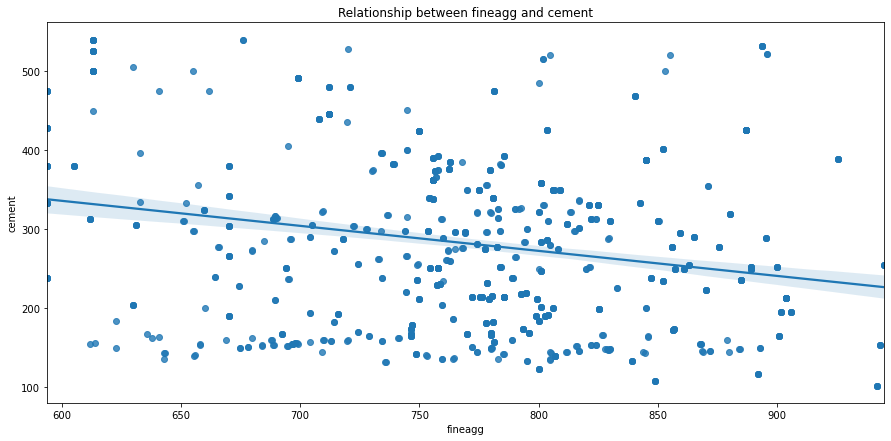

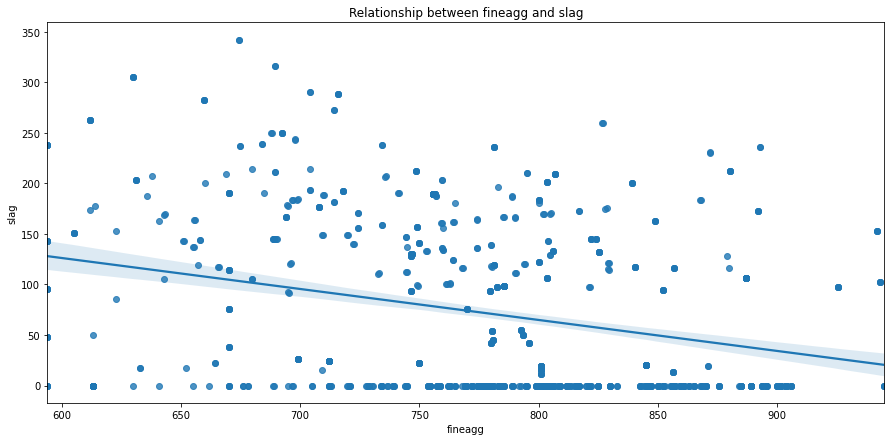

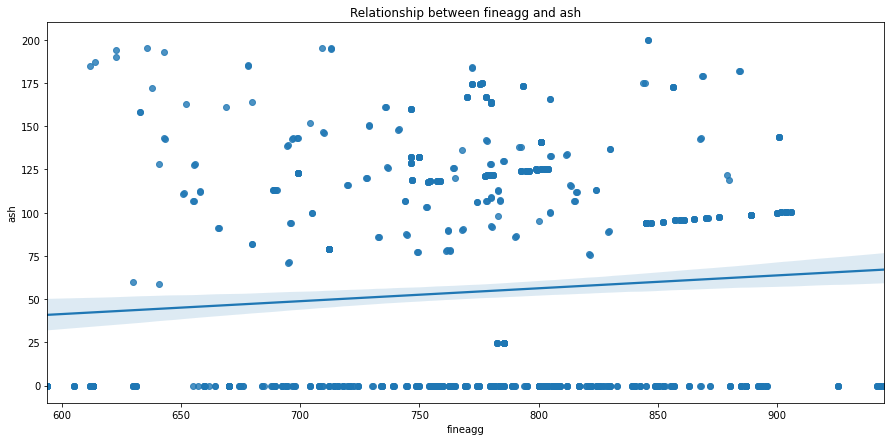

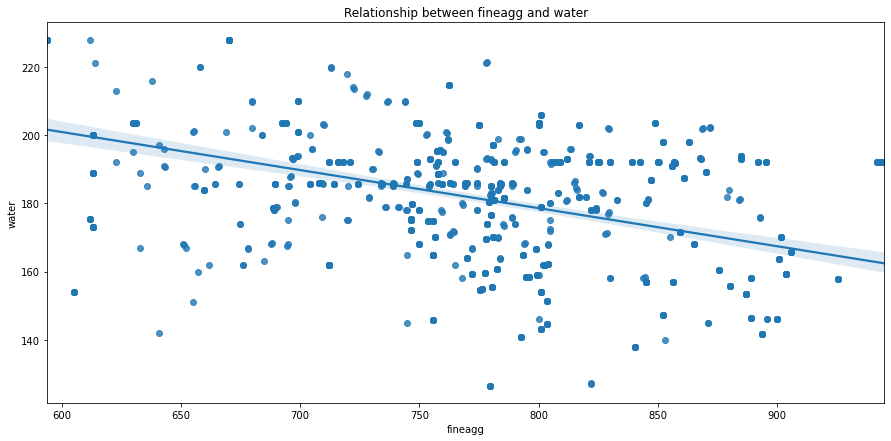

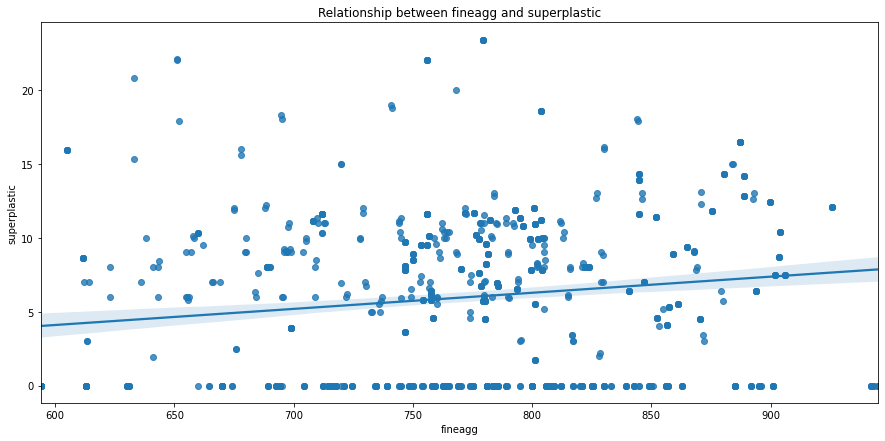

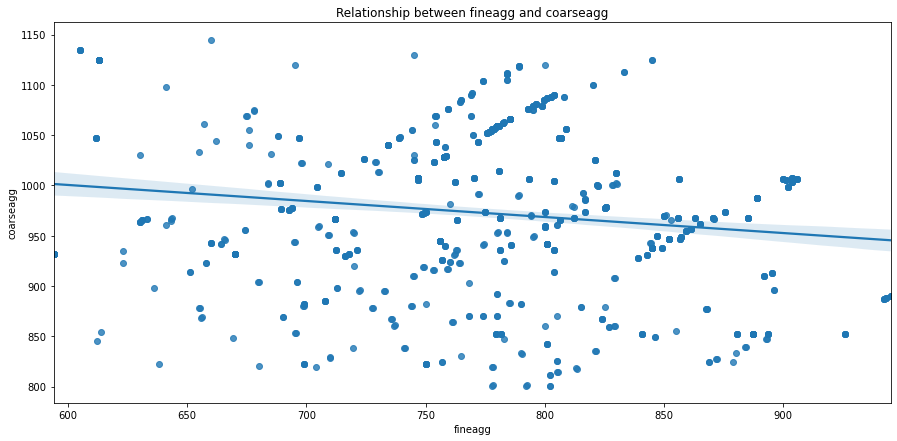

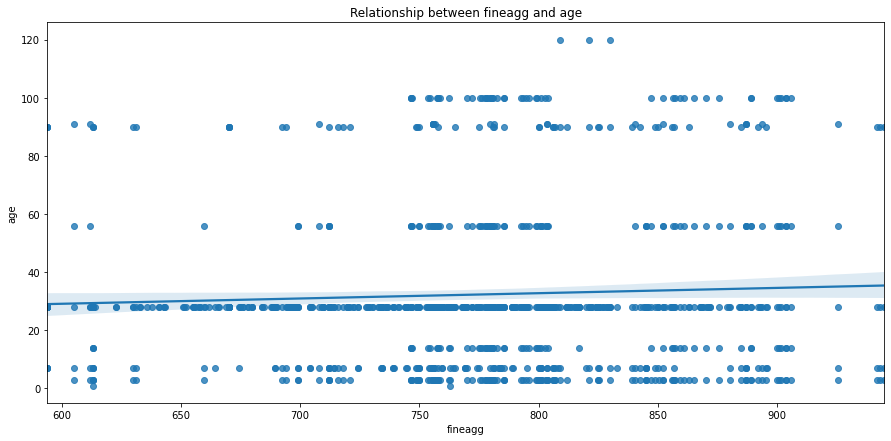

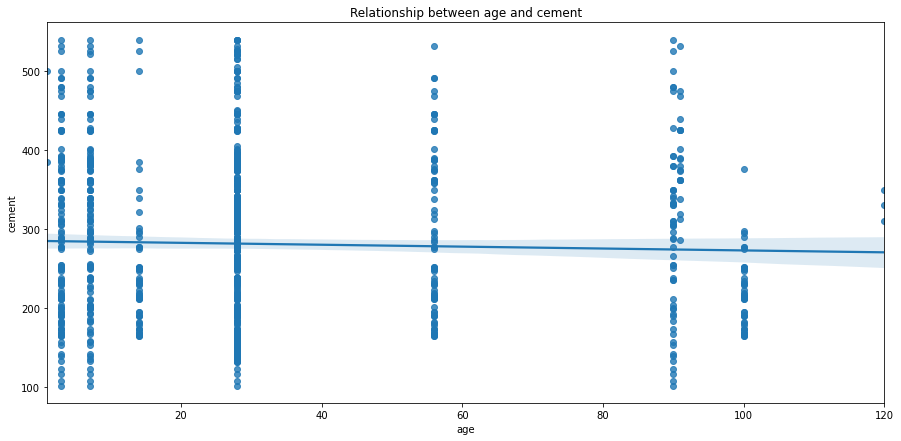

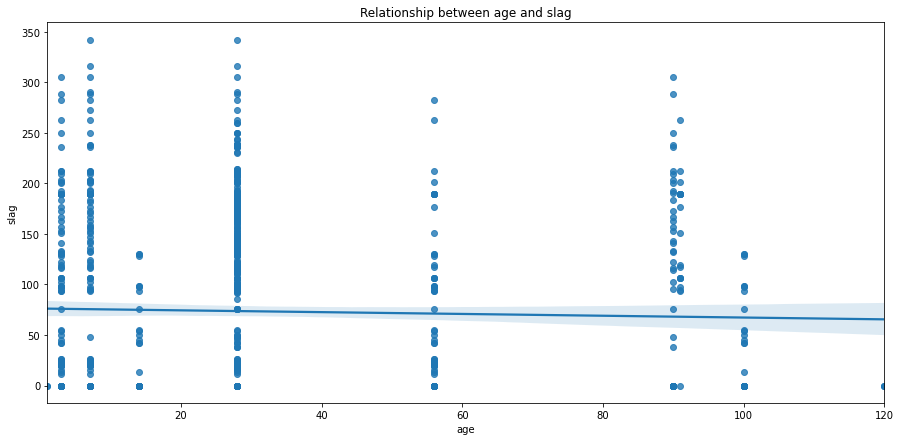

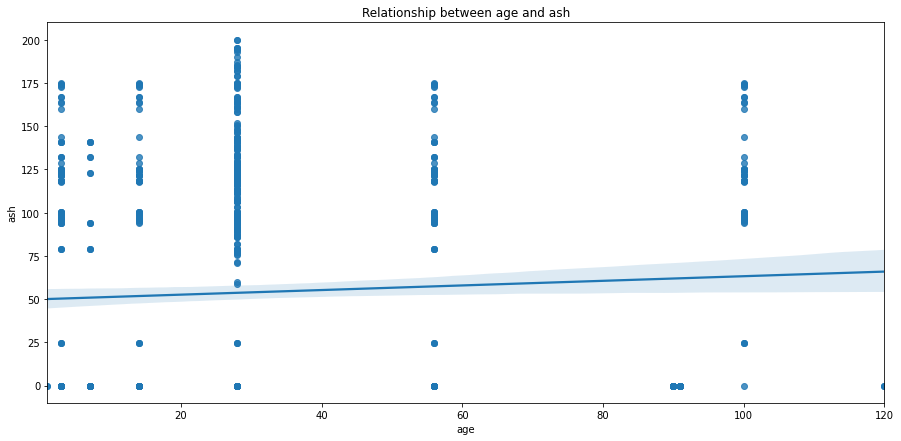

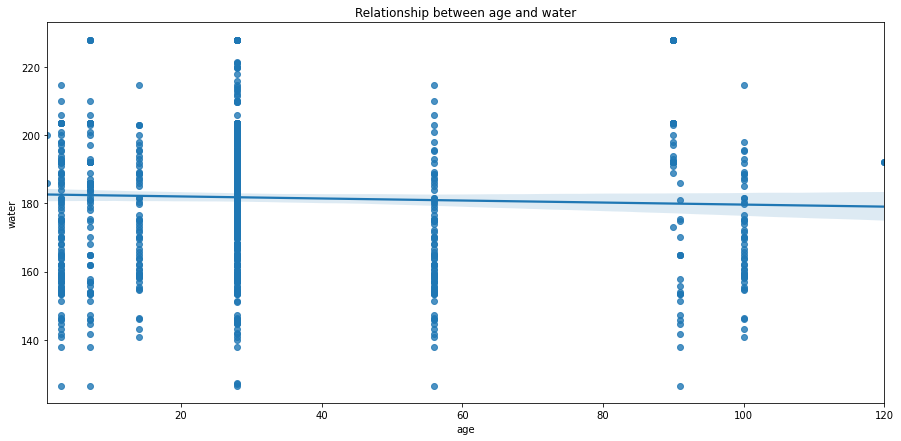

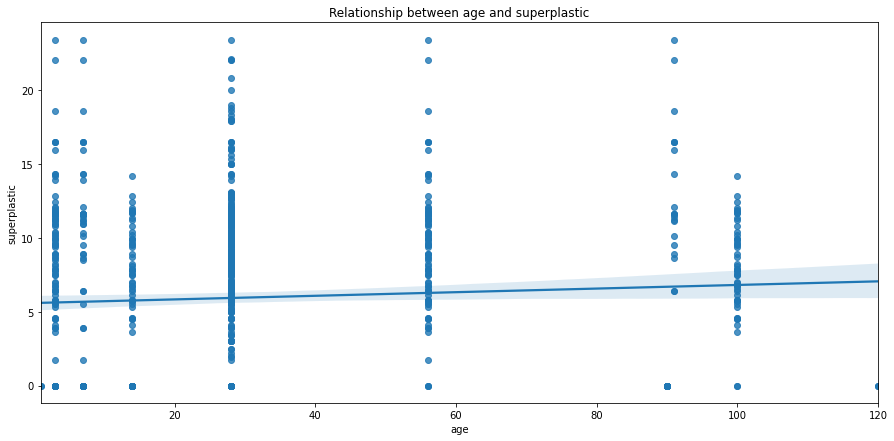

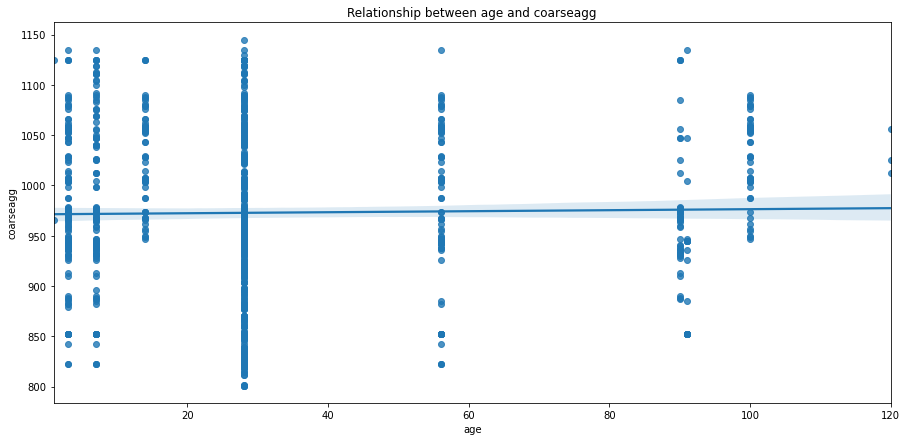

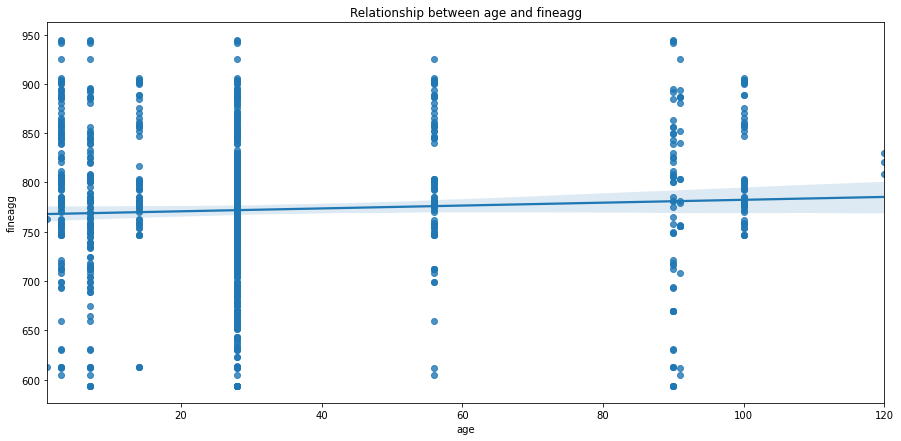

In [19]:
## Multivariate analysis for every feature comparison
# col_copy_list = list(df.columns).copy()
# merge_list = [list(df.columns),col_copy_list]
# plot_list = list(itertools.product(*merge_list))
# for col1, col2 in plot_list:
#     fig,ax1 = plt.subplots(figsize=(15,7),sharex=False)
#     sns.regplot(x=col1, y=col2,data=df,ax=ax1).set_title(f'Relationship between {col1} and {col2}')

# Another easy method
for col1 in list(x.columns):
    for col2 in list(x.columns):
        if col1 != col2:
            fig,ax1 = plt.subplots(figsize=(15,7),sharex=False)
            sns.regplot(x=df[col1],y=df[col2],ax=ax1).set_title(f'Relationship between {col1} and {col2}')

## Checking multicolinearity

In [20]:
## Checking for multi colinearity using corelation matrix
corrmat = x.corr()
corrmat

cement      slag       ash     water  superplastic  coarseagg  \
cement        1.000000 -0.275046 -0.397467 -0.091614      0.013336  -0.109349   
slag         -0.275046  1.000000 -0.320468  0.098880      0.061195  -0.283882   
ash          -0.397467 -0.320468  1.000000 -0.248011      0.447492  -0.009961   
water        -0.091614  0.098880 -0.248011  1.000000     -0.658056  -0.156928   
superplastic  0.013336  0.061195  0.447492 -0.658056      1.000000  -0.224503   
coarseagg    -0.109349 -0.283882 -0.009961 -0.156928     -0.224503   1.000000   
fineagg      -0.238698 -0.282383  0.091729 -0.426299      0.156591  -0.161377   
age          -0.031962 -0.028971  0.057928 -0.040304      0.062013   0.018078   

               fineagg       age  
cement       -0.238698 -0.031962  
slag         -0.282383 -0.028971  
ash           0.091729  0.057928  
water        -0.426299 -0.040304  
superplastic  0.156591  0.062013  
coarseagg    -0.161377  0.018078  
fineagg       1.000000  0.051532  
age           0.051532  1.000000

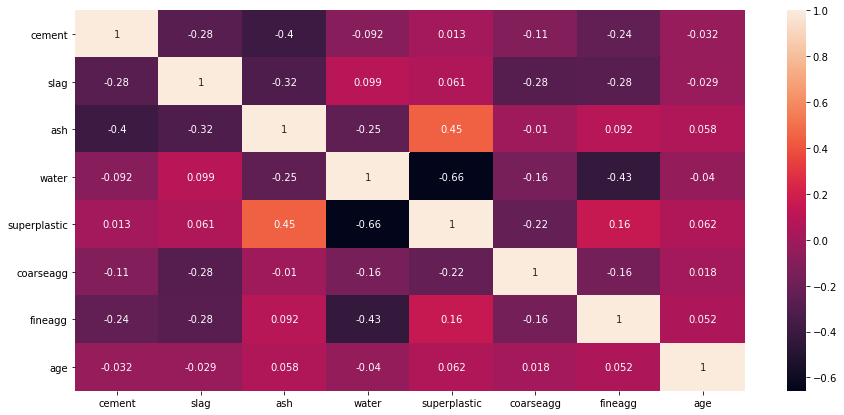

In [21]:
fig,ax = plt.subplots(figsize=(15,7))
sns.heatmap(corrmat,annot=True)

## checking colineariy using Variance inflation index or Factor method

In [22]:
## Working of VIF
# Step 1: It regresses every independent variable with each other and calculates the R square value
# Step 2: The VIF for the variable is calculated  by the formula Vif = 1/(1-r^2)
## If the VIF of the variable is greater than 5 then the variable is multicolinear

def vifcolinearity(x):
    vif = pd.DataFrame()
    vif['feature_names'] = x.columns
    vif['vif_factor'] = [variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
    return vif.sort_values(by='vif_factor',ascending=False).round(2)

In [23]:
vifcolinearity(x)

feature_names  vif_factor
5     coarseagg       86.94
3         water       81.96
6       fineagg       68.66
0        cement       14.29
4  superplastic        5.72
2           ash        4.42
1          slag        3.34
7           age        2.37

In [24]:
# Feature dimension reduction (PCA)
def applypca(x):
    ncomponents = len(x.columns)
    # scaling the data
    x = StandardScaler().fit_transform(x)
    # applying pca
    for j in range(1,ncomponents):
        pca = PCA(n_components=j)
        pcomponents = pca.fit_transform(x)
        exp_var_ratio = np.cumsum(pca.explained_variance_ratio_)
        if exp_var_ratio[j - 1] >= 0.95:
            ncomponents = j
            break
    print("explained variance ratio after PCA is", exp_var_ratio)
    # creating dataframe of components
    col = []
    for i in range(1,ncomponents+1):
        col.append("PC"+str(i))
    pcomp = pd.DataFrame(data=pcomponents,columns=col)
    return pcomp

In [25]:
new_x = applypca(x)

explained variance ratio after PCA is [0.27112429 0.44666571 0.60914114 0.73584634 0.85926016 0.97264602]


In [26]:
new_x

PC1       PC2       PC3       PC4       PC5       PC6
0     1.810919  1.331664 -1.284484 -0.306148 -0.067652 -0.886110
1    -1.823833 -0.573436 -1.058973  0.893130 -0.913984 -0.751061
2    -0.739819 -0.463200 -0.541643 -1.033210 -0.308068  0.611045
3     2.766368  0.602978 -0.512532  0.008806  0.086415  0.850548
4     0.892523  0.966627 -0.863624  1.148561 -0.064439 -1.221228
...        ...       ...       ...       ...       ...       ...
1025 -1.743036  0.071059 -1.492203  0.045227 -0.449481  0.968953
1026 -1.079147 -0.572265  3.269799 -1.669125 -0.962953  0.002303
1027 -0.494143  1.276989  0.318398 -0.053272 -0.153787  0.751019
1028  2.688411 -0.236744  0.056551 -0.088955  0.105206  1.368321
1029  1.824507 -2.656185  1.641783  1.924398 -0.624415 -0.394357

[1030 rows x 6 columns]

In [27]:
vifcolinearity(new_x)

feature_names  vif_factor
0           PC1         1.0
5           PC6         1.0
1           PC2         1.0
3           PC4         1.0
4           PC5         1.0
2           PC3         1.0

## Model Building

In [28]:
# Train test split

In [29]:
def traintestsplit(x,y, test_size=0.3):
    return train_test_split(x,y,test_size=test_size,random_state=10)

In [30]:
# Building and fitting model

In [31]:
def modelbuilding(model_name,model,x,y,test_size=0.3):
    x_train,x_test,y_train,y_test = traintestsplit(x,y)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    r2_score_val = r2_score(y_test,y_pred)
    li = [model_name,r2_score_val,rmse]
    return li

In [32]:
# Building each and every model

In [33]:
def buildmodels(x,y):
    col_names = ['Model_name','R_sqr value','RMSE']
    result = pd.DataFrame(columns=col_names)
    result.loc[len(result)] = modelbuilding('LinearRegression',LinearRegression(),x,y)
    result.loc[len(result)] = modelbuilding('Lasso',Lasso(),x,y)
    result.loc[len(result)] = modelbuilding('Ridge',Ridge(),x,y)
    result.loc[len(result)] = modelbuilding('DecisionTreeRegressor',DecisionTreeRegressor(),x,y)
    result.loc[len(result)] = modelbuilding('AdaBoostRegressor',AdaBoostRegressor(),x,y)
    result.loc[len(result)] = modelbuilding('RandomForestRegressor',RandomForestRegressor(),x,y)
    result.loc[len(result)] = modelbuilding('SVR',SVR(),x,y)
    result.loc[len(result)] = modelbuilding('KNeighborsRegressor',KNeighborsRegressor(),x,y)
    result.loc[len(result)] = modelbuilding('GradientBoostingRegressor',GradientBoostingRegressor(),x,y)
    result.loc[len(result)] = modelbuilding('XGBRegressor',XGBRegressor(),x,y)
    return result

In [34]:
output = buildmodels(new_x,y)

In [35]:
output

Model_name  R_sqr value      RMSE
0           LinearRegression     0.677259  9.107669
1                      Lasso     0.658662  9.366386
2                      Ridge     0.677174  9.108865
3      DecisionTreeRegressor     0.787115  7.396953
4          AdaBoostRegressor     0.734911  8.254216
5      RandomForestRegressor     0.854812  6.108645
6                        SVR     0.707881  8.664832
7        KNeighborsRegressor     0.736550  8.228651
8  GradientBoostingRegressor     0.825694  6.693230
9               XGBRegressor     0.863192  5.929740

## Cross validation
#### For higher algorithms cross validation is required for buildmodels (lasso,ridge.boosting...)

In [36]:
def kfoldcv(x,y,folds=10): # randonly folded so multicolinearity disappears so use main x and y
    lr = LinearRegression()
    lasso = Lasso()
    ridge = Ridge()
    dt = DecisionTreeRegressor()
    ada = AdaBoostRegressor()
    rf = RandomForestRegressor()
    svr = SVR()
    knn = KNeighborsRegressor()
    gb = GradientBoostingRegressor()
    xgb = XGBRegressor()
    
    # Scoring using cross validation
    score_lr = cross_val_score(lr,x,y,cv=folds)
    score_lasso = cross_val_score(lasso,x,y,cv=folds)
    score_ridge = cross_val_score(ridge,x,y,cv=folds)
    score_dt = cross_val_score(dt,x,y,cv=folds)
    score_ada = cross_val_score(ada,x,y,cv=folds)
    score_rf = cross_val_score(rf,x,y,cv=folds)
    score_svr = cross_val_score(svr,x,y,cv=folds)
    score_knn = cross_val_score(knn,x,y,cv=folds)
    score_gb = cross_val_score(gb,x,y,cv=folds)
    score_xgb = cross_val_score(xgb,x,y,cv=folds)
    
    # Building output frame
    models = [lr,lasso,ridge,dt,ada,rf,svr,knn,gb,xgb]
    model_names = ['LinearRegression','Lasso','Ridge','DecisionTree','AdaBoost','RandomForest','SVR','KNeighbors','GradientBoosting','XGBoosting']
    scores = [score_lr,score_lasso,score_ridge,score_dt,score_ada,score_rf,score_svr,score_knn,score_gb,score_xgb]
    result = []
    for idx in range(0, len(models)):
        score_mean = round(np.mean(scores[idx])*100 ,2)
        score_std = np.std(scores[idx])
        m_name = model_names[idx]
        temp = [m_name,score_mean,score_std]
        result.append(temp)
    result_df = pd.DataFrame(result,columns=['Model_name','Average_accuracy','Accuracy_stdev'])
    return result_df

In [37]:
kfoldcv(x,y)

Model_name  Average_accuracy  Accuracy_stdev
0  LinearRegression             68.69        0.062430
1             Lasso             68.67        0.062488
2             Ridge             68.69        0.062431
3      DecisionTree             83.22        0.052191
4          AdaBoost             74.13        0.029689
5      RandomForest             88.74        0.036084
6               SVR             23.35        0.038865
7        KNeighbors             66.80        0.086449
8  GradientBoosting             87.76        0.044889
9        XGBoosting             90.23        0.041982

#### Observations:
###### Avg mean should be high whereas avg std should be low
###### Here: 1.XGB,2.RF,3.GB
###### If Linear reg has high accuracy then select it because LR is simple and easy to build

In [38]:
kfoldcv(new_x,y) # if client asks us to deploy after PCA use this pca's new_x data.

Model_name  Average_accuracy  Accuracy_stdev
0  LinearRegression             66.39        0.059476
1             Lasso             64.98        0.049887
2             Ridge             66.39        0.059437
3      DecisionTree             76.90        0.054428
4          AdaBoost             72.90        0.041762
5      RandomForest             86.53        0.034771
6               SVR             70.31        0.042765
7        KNeighbors             76.78        0.055700
8  GradientBoosting             82.90        0.050364
9        XGBoosting             87.33        0.036061

## Hyper parameter tuning 

## Building model with best parameters

In [39]:
def gridsearchcv(model_name,estimator,param_grid,x,y):
    parameterized_model = GridSearchCV(estimator=estimator,param_grid=param_grid,cv=5,verbose=1,n_jobs=-1)
    x_train,x_test,y_train,y_test = traintestsplit(x,y)
    parameterized_model.fit(x_train,y_train)
    best_params = parameterized_model.best_params_
    params_li = [model_name,best_params]
    print(params_li)
    return params_li

In [40]:
def hyperparameterbuildmodels(x,y):
    # assigning parameters to find best_params
    ridge_param = {'alpha':[0,0.1,0.2,0.3,0.4,1,3,4,0.6,1.3,1.6,2.5,4,20,39,88,101,150,180,208,301,333,378,467,689]}
    lasso_param = {'alpha':[0,0.1,0.2,0.3,0.4,1,3,4,0.6,1.3,1.6,2.5,4,20,39,88,101,150,180,208,301,333,378,467,689]}
    gb_params = {'learning_rate':[1e-15,1e-12,1e-8,1e-4,1e-2,0.5,0.6,0.7,0.8,1],'max_leaf_nodes':[3,4,5,6,7,8,9,10,12,15,25,29,37]}
    xgb_params = {'learning_rate':[0.3,0.6],'max_depth':[3,4,5,6,7,8,9],'gamma':[0,10,55,73],'alpha':[0,23,67,103]}
    knn_params = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,28,36,39,40,42,46,50]}
    
    col_names = ['Model_name','Best_parameter']
    result = pd.DataFrame(columns=col_names)
    result.loc[len(result)] = gridsearchcv('Lasso',Lasso(),lasso_param,x,y)
    result.loc[len(result)] = gridsearchcv('Ridge',Ridge(),ridge_param,x,y)
    result.loc[len(result)] = gridsearchcv('KNeighborsRegressor',KNeighborsRegressor(),knn_params,x,y)
    result.loc[len(result)] = gridsearchcv('GradientBoostingRegressor',GradientBoostingRegressor(),gb_params,x,y)
    result.loc[len(result)] = gridsearchcv('XGBRegressor',XGBRegressor(),xgb_params,x,y)
    return result

In [41]:
hyperparameter_output = hyperparameterbuildmodels(new_x,y)
hyperparameter_output

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


['Lasso', {'alpha': 0.1}]
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Done 118 out of 125 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


['Ridge', {'alpha': 4}]
Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


['KNeighborsRegressor', {'n_neighbors': 3}]
Fitting 5 folds for each of 130 candidates, totalling 650 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 650 out of 650 | elapsed:   53.9s finished


['GradientBoostingRegressor', {'learning_rate': 0.5, 'max_leaf_nodes': 25}]
Fitting 5 folds for each of 224 candidates, totalling 1120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   59.6s


['XGBRegressor', {'alpha': 23, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 5}]


[Parallel(n_jobs=-1)]: Done 1120 out of 1120 | elapsed:  1.3min finished


Model_name  \
0                      Lasso   
1                      Ridge   
2        KNeighborsRegressor   
3  GradientBoostingRegressor   
4               XGBRegressor   

                                      Best_parameter  
0                                     {'alpha': 0.1}  
1                                       {'alpha': 4}  
2                                 {'n_neighbors': 3}  
3       {'learning_rate': 0.5, 'max_leaf_nodes': 25}  
4  {'alpha': 23, 'gamma': 0, 'learning_rate': 0.3...

In [42]:
# model building with best parameters
def bestparamModels(x,y):
    col_names = ['Model_name','R_sqr value','RMSE']
    result = pd.DataFrame(columns=col_names)
    result.loc[len(result)] = modelbuilding('Lasso',Lasso(alpha=0.1),x,y)
    result.loc[len(result)] = modelbuilding('Ridge',Ridge(alpha=4),x,y)
    result.loc[len(result)] = modelbuilding('KNeighborsRegressor',KNeighborsRegressor(n_neighbors=3),x,y)
    result.loc[len(result)] = modelbuilding('GradientBoostingRegressor',GradientBoostingRegressor(learning_rate =0.5,max_leaf_nodes=8),x,y)
    result.loc[len(result)] = modelbuilding('XGBRegressor',XGBRegressor(learning_rate =0.3,max_depth=5,alpha=23,gamma=0),x,y)
    return result

In [43]:
hyperparameter_result = bestparamModels(new_x,y)
hyperparameter_result

Model_name  R_sqr value      RMSE
0                      Lasso     0.677257  9.107690
1                      Ridge     0.676910  9.112581
2        KNeighborsRegressor     0.741561  8.150025
3  GradientBoostingRegressor     0.827993  6.648954
4               XGBRegressor     0.863799  5.916576

In [44]:
# kfoldcv after parameter tuning
def kfoldcvparameterized(x,y,folds=10):
    lasso = Lasso(alpha=0.1)
    ridge = Ridge(alpha=4)
    knn = KNeighborsRegressor(n_neighbors=3)
    gb = GradientBoostingRegressor(learning_rate =0.5,max_leaf_nodes=8)
    xgb = XGBRegressor(learning_rate =0.3,max_depth=5,alpha=23,gamma=0)
    
    # Scoring using cross validation
    score_lasso = cross_val_score(lasso,x,y,cv=folds)
    score_ridge = cross_val_score(ridge,x,y,cv=folds)
    score_knn = cross_val_score(knn,x,y,cv=folds)
    score_gb = cross_val_score(gb,x,y,cv=folds)
    score_xgb = cross_val_score(xgb,x,y,cv=folds)
    
    # Building output frame
    models = [lasso,ridge,knn,gb,xgb]
    model_names = ['Lasso','Ridge','KNeighbors','GradientBoosting','XGBoosting']
    scores = [score_lasso,score_ridge,score_knn,score_gb,score_xgb]
    result = []
    for idx in range(0, len(models)):
        score_mean = round(np.mean(scores[idx])*100 ,2)
        score_std = np.std(scores[idx])
        m_name = model_names[idx]
        temp = [m_name,score_mean,score_std]
        result.append(temp)
    result_df = pd.DataFrame(result,columns=['Model_name','Average_accuracy','Accuracy_stdev'])
    return result_df

In [45]:
kfoldcvparameterized(x,y)

Model_name  Average_accuracy  Accuracy_stdev
0             Lasso             68.69        0.062433
1             Ridge             68.69        0.062431
2        KNeighbors             68.66        0.083678
3  GradientBoosting             88.57        0.054597
4        XGBoosting             89.65        0.040109

## Cluster Analysis

In [46]:
x = df2.drop('strength',axis=1)
y = df2[['strength']]

In [47]:
from sklearn.cluster import KMeans

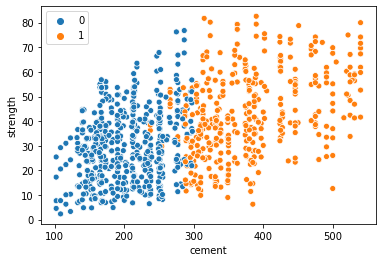

In [48]:
labels =KMeans(n_clusters=2,random_state=100).fit_predict(x)
sns.scatterplot(df2.cement,df2.strength,hue=labels)

In [49]:
# Plotting Clusters between independent variables
def Kmeansplot(x,t_col,labels):
    columns = list(set(list(x.columns)) - set([t_col])) # Prevent clustering between same variables
    r = int(len(columns)/2)
    if r%2 == 0:
        r = r
    else:
        r = r+1
    
    # Plotting graphs(cluster plots)
    f,ax = plt.subplots(r,2,figsize=(15,15)) # proper sets of rows and columns so we used above r calculation
    a = 0
    for col in range(0,r):
        for j in range(0,2):
            if a != len(columns):
                ax[col][j].scatter(x[t_col],x[columns[a]],c=labels)
                ax[col][j].set_xlabel(t_col)
                ax[col][j].set_ylabel(columns[a])
                a = a+1

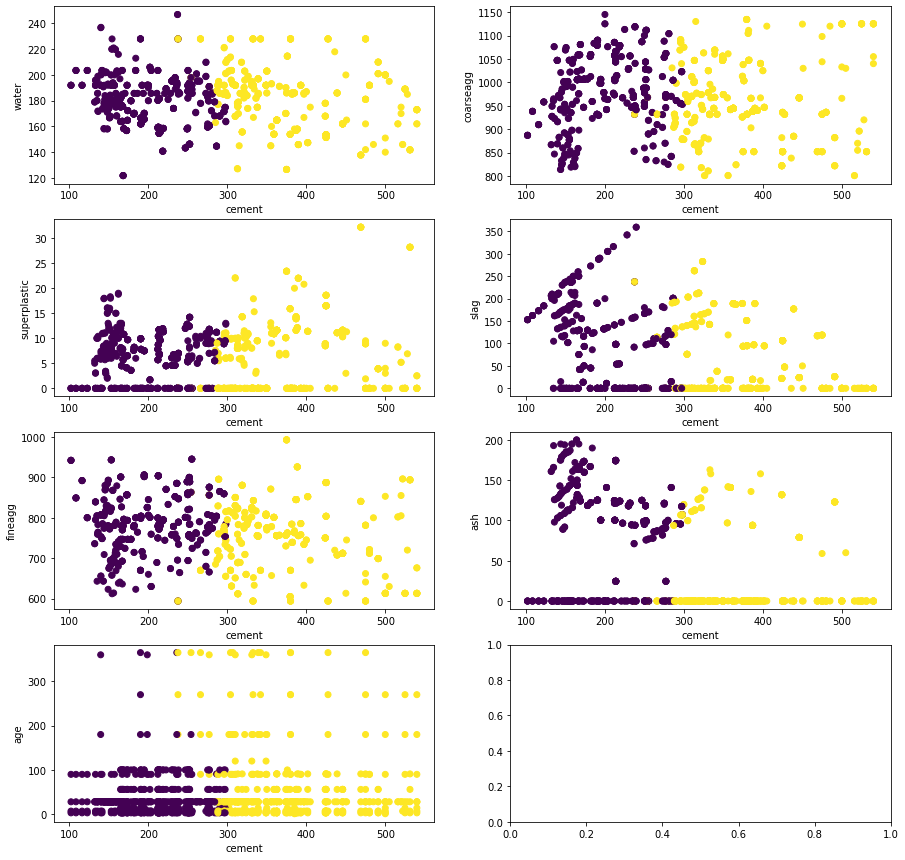

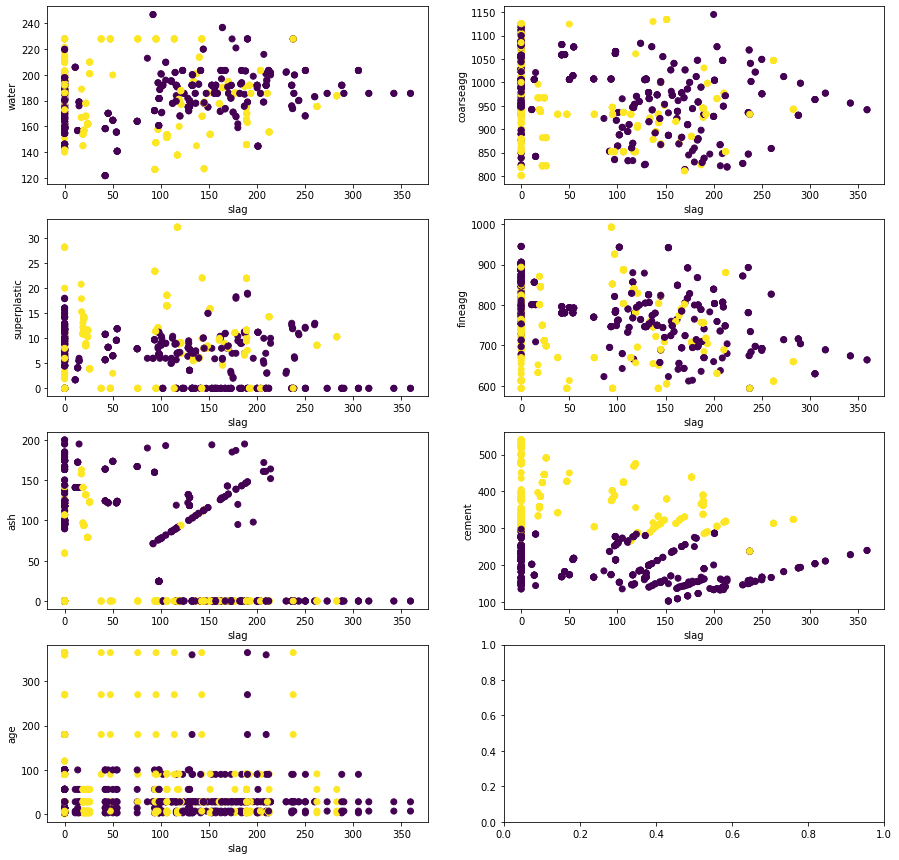

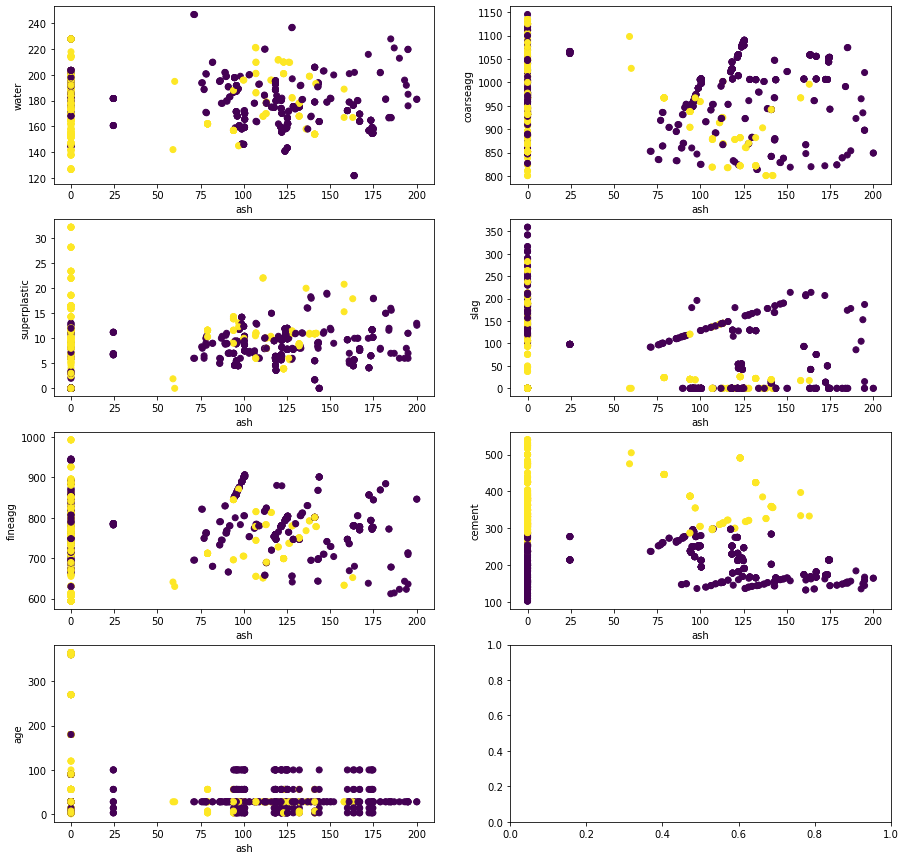

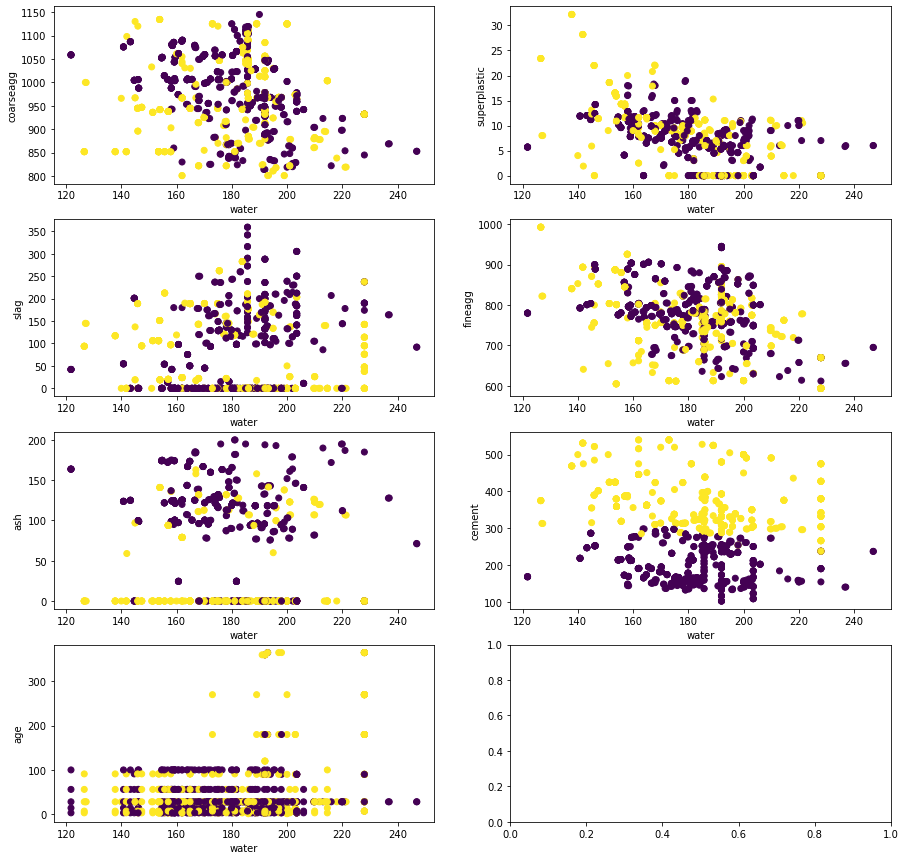

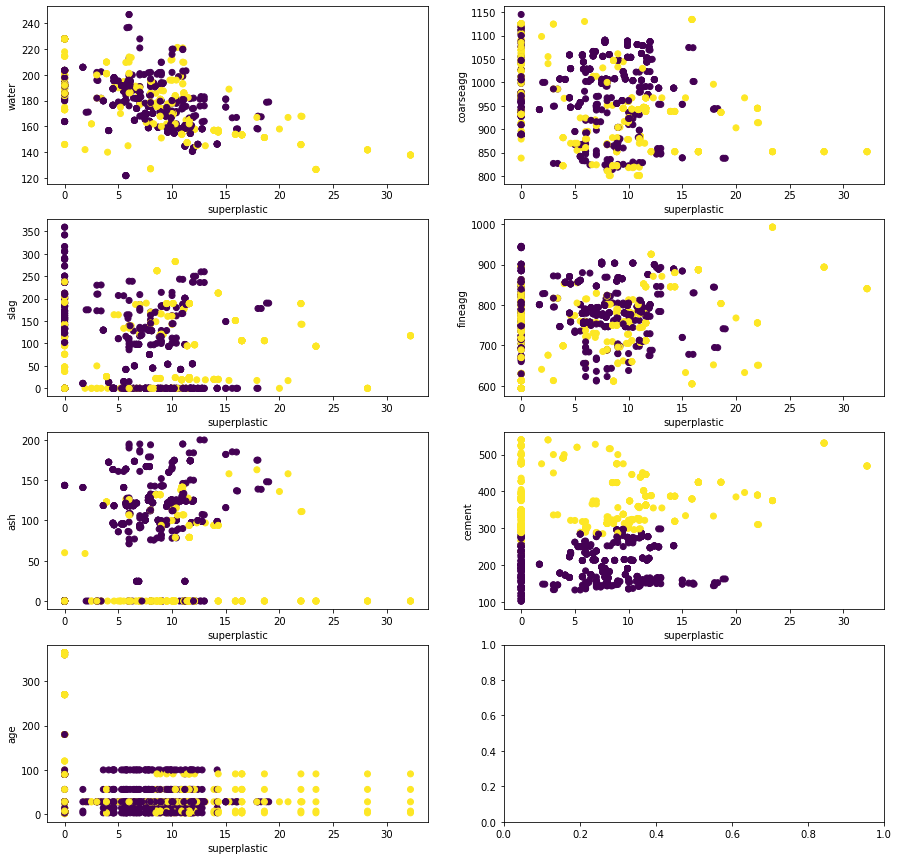

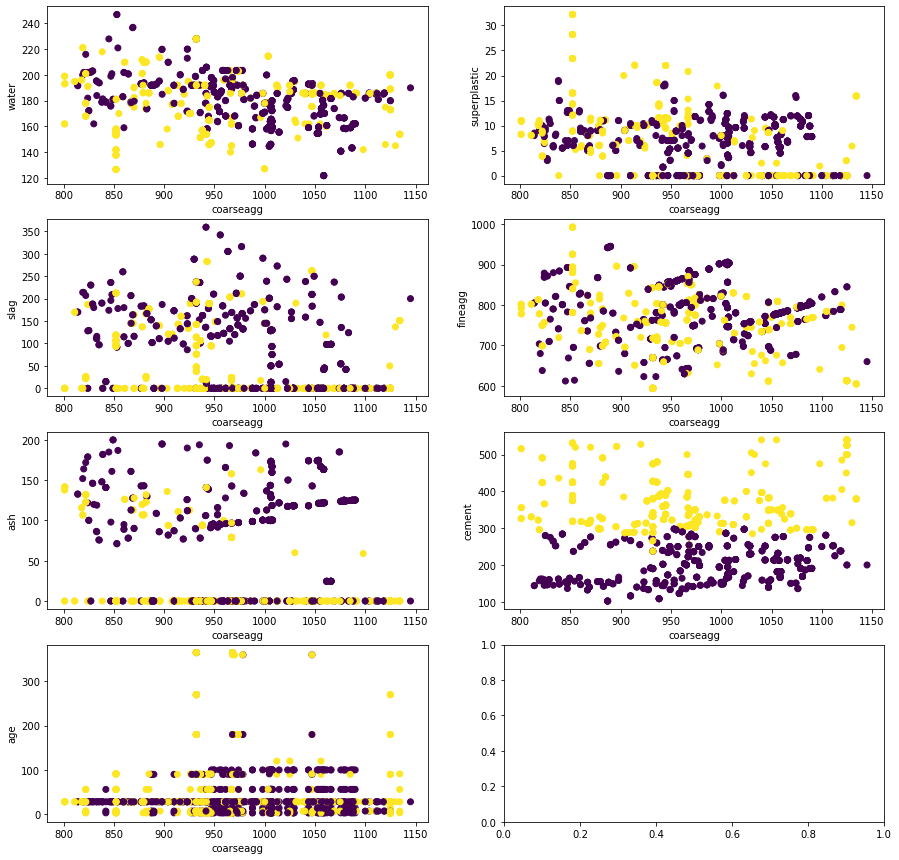

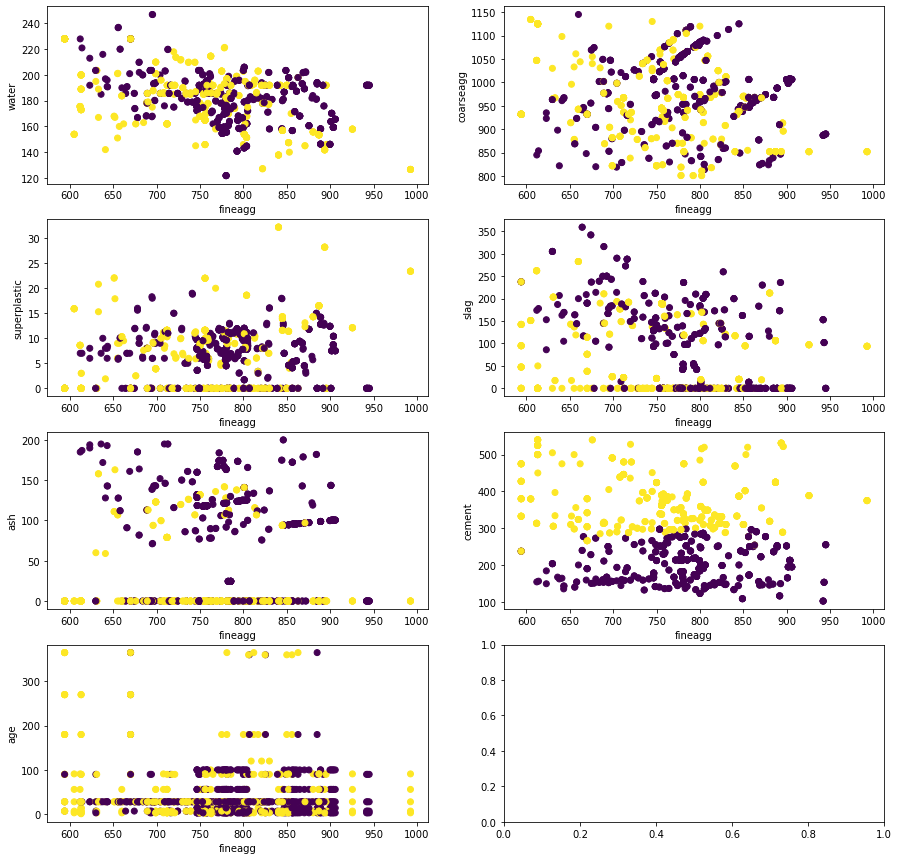

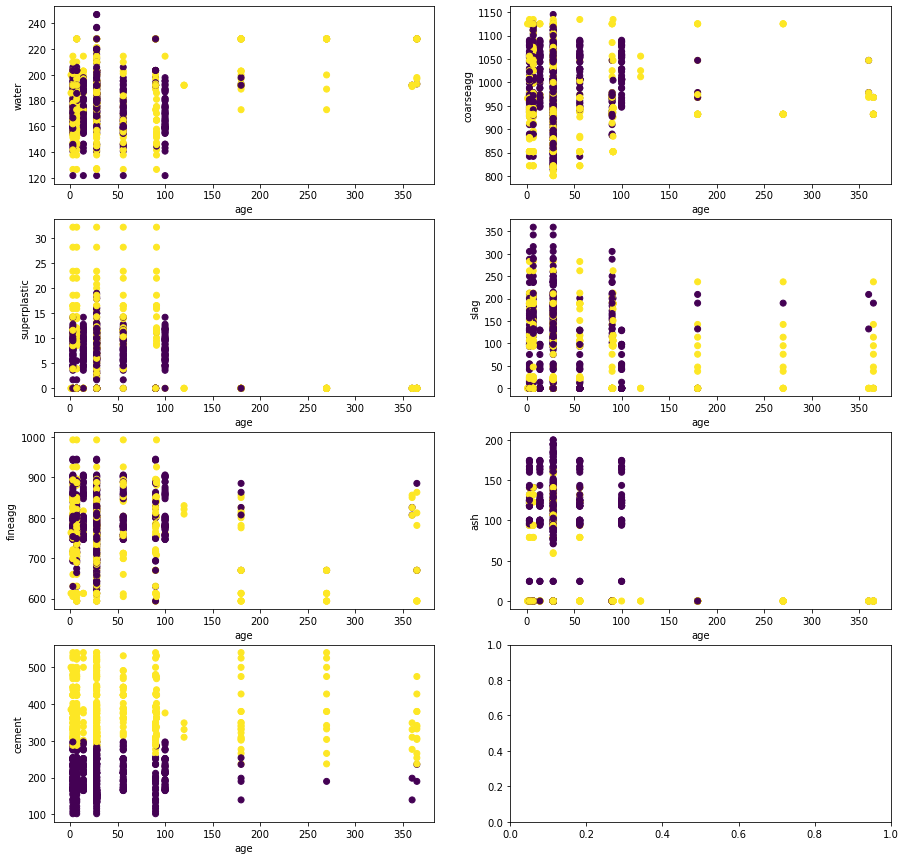

In [50]:
for col in x.columns:
    Kmeansplot(x,col,labels)